In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

%run ..\..\..\..\funcoes_base_global\funcoes_plot.py
%run ..\..\0_funcoes_base\read_sap_intervencoes.py

#### Local dos Dados de Entrada

In [2]:
input_path = os.path.join('out','')

#### Base SAP

In [3]:
dicionario_sap, dicionario_intervencoes, dicionario_important_dates = dicionario()

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
corr = [[x, y] for x, y in dicionario_important_dates.items() if y == 'Corr.']
corr = dict(corr)

#### Base de Dados

In [5]:
df = pd.read_csv(input_path+'df_temperatura_modelo_linear.csv.gz', compression = 'gzip', parse_dates = ['Date'], index_col = 'Date')
df.head()

,Temp_Desc_2,Temp_Desc_2_shift,Temp_Desc_1,Pot_Cons,Temp_Suc_2,AI25121.PV,AI25131.PV,AI25141.PV,AI25151.PV,AI25161.PV,AI25171.PV,AI25181.PV,AI25191.PV,AI25211.PV
Date,,,,,,,,,,,,,,
2015-01-09 20:46:00,123.4360,23.5,91.4725,501.658,39.994,37.447,9.021,0.021,30.703,8.978,2.103,3.206,0.435,8.334
2015-01-09 20:47:00,129.9625,23.5,93.9860,528.117,40.994,37.502,9.046,0.021,30.693,8.926,2.064,3.190,0.428,8.334
2015-01-09 20:48:00,133.4770,23.5,95.9870,522.236,41.000,37.503,9.046,0.021,30.693,8.926,2.064,3.190,0.428,8.334
2015-01-09 20:49:00,135.9850,23.5,98.4845,516.954,41.000,37.503,9.046,0.021,30.693,8.926,2.064,3.190,0.428,8.334
2015-01-09 20:50:00,136.4965,23.5,98.9965,587.671,41.993,37.503,9.046,0.021,30.693,8.926,2.064,3.190,0.428,8.380


In [6]:
df.dropna(inplace = True)

#### Separação dos Dados de Treino e Teste

In [15]:
# Variáveis de Entrada e Saída
saida   = ['Temp_Desc_2']

shift_out = True
if shift_out:
    entrada = [x for x in df.columns if x not in saida]
else:
    entrada = [x for x in df.columns if x not in saida]
    entrada = [x for x in entrada if 'shift' not in x]

# Seleção dos dados de Treino e Teste - Bootstrapping
from sklearn.utils import resample
data = df.dropna()
# prepare bootstrap sample
train = resample(data, replace = True, n_samples = 100000, random_state = 42)
print('Bootstrap Train Sample:'+str(train.shape))
# out of bag observations
test = data[~data.index.isin(train)]
print('Bootstrap Test  Sample: '+str(test.shape))

#Entrada Treino e Teste
X_train = train[entrada]
X_test  = test[entrada]

#Saída Treino e Teste
Y_train = train[saida]
Y_test  = test[saida]

Bootstrap Train Sample:(100000, 14)
Bootstrap Test  Sample: (1284506, 14)


#### Ajustando o Modelo

In [23]:
%%time

# Métricas de Erro
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error

# Treinamento do Modelo
rlm = sm.RLM(Y_train, X_train,  M = sm.robust.norms.AndrewWave()).fit()
print('Avaliação do Modelo Linear - Treino:')
print('R²: ', str(r2_score(Y_train, rlm.predict(X_train))))
print('Erro Mediano: ', str(median_absolute_error(Y_train, rlm.predict(X_train))))
print('Erro Médio Quadrático: ', str(mean_squared_error(Y_train, rlm.predict(X_train))))
print('--------------------------------------')
print('Avaliação do Modelo Linear - Teste:')
print('R²: ', str(r2_score(Y_test, rlm.predict(X_test))))
print('Erro Mediano: ', str(median_absolute_error(Y_test, rlm.predict(X_test))))
print('Erro Médio Quadrático: ', str(mean_squared_error(Y_test, rlm.predict(X_test))))
print('--------------------------------------')

Avaliação do Modelo Linear - Treino:
R²:  -0.7513243214097922
Erro Mediano:  1.5963006962007853
Erro Médio Quadrático:  60.41386336464794
--------------------------------------
Avaliação do Modelo Linear - Teste:
R²:  -0.8108419743077844
Erro Mediano:  1.6005199392259044
Erro Médio Quadrático:  62.159249184950525
--------------------------------------
Wall time: 4.67 s


In [24]:
rlm.params

Temp_Desc_2_shift    0.571143
Temp_Desc_1          0.377594
Pot_Cons            -0.009263
Temp_Suc_2           0.155652
AI25121.PV           0.170358
AI25131.PV           0.044096
AI25141.PV           7.583628
AI25151.PV           0.185782
AI25161.PV           0.248739
AI25171.PV           0.605041
AI25181.PV           0.204555
AI25191.PV           3.458247
AI25211.PV           0.518849
dtype: float64

In [25]:
def predict_value(df, columns, model):
    X = df[columns]
    Y = model.predict(X)
    return Y

In [26]:
%%time
prediction_variable = saida[0]+'_Predict'
df_test = df.dropna().copy()
df_test[prediction_variable] = predict_value(df_test, entrada, rlm)
df_test['Error'] = np.zeros(df_test.shape[0])
df_test['Error'] = np.abs(df_test[saida[0]] - df_test[prediction_variable])

Wall time: 733 ms


#### Avaliação Gráfica do Modelo Linear

#### 2017

0
(382798, 1)


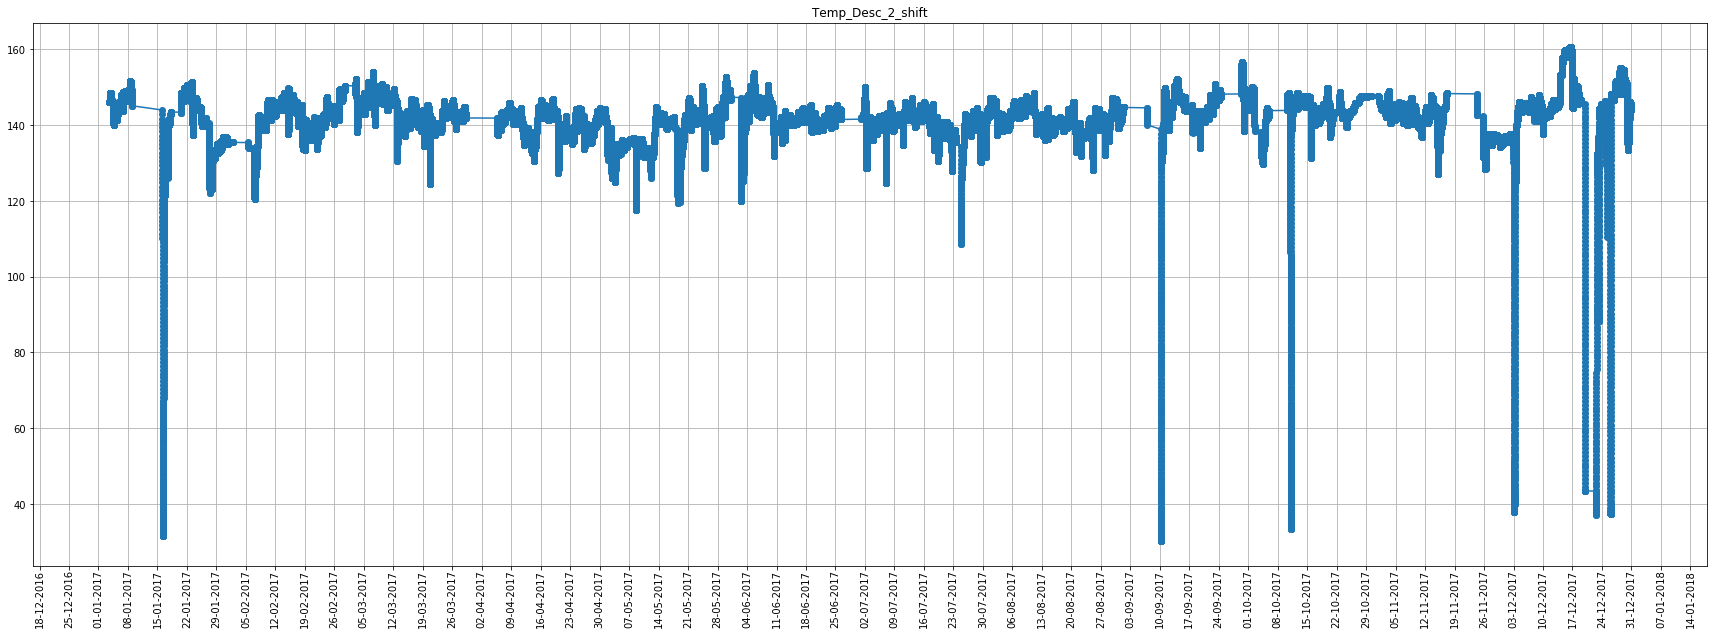

1
(382798, 1)


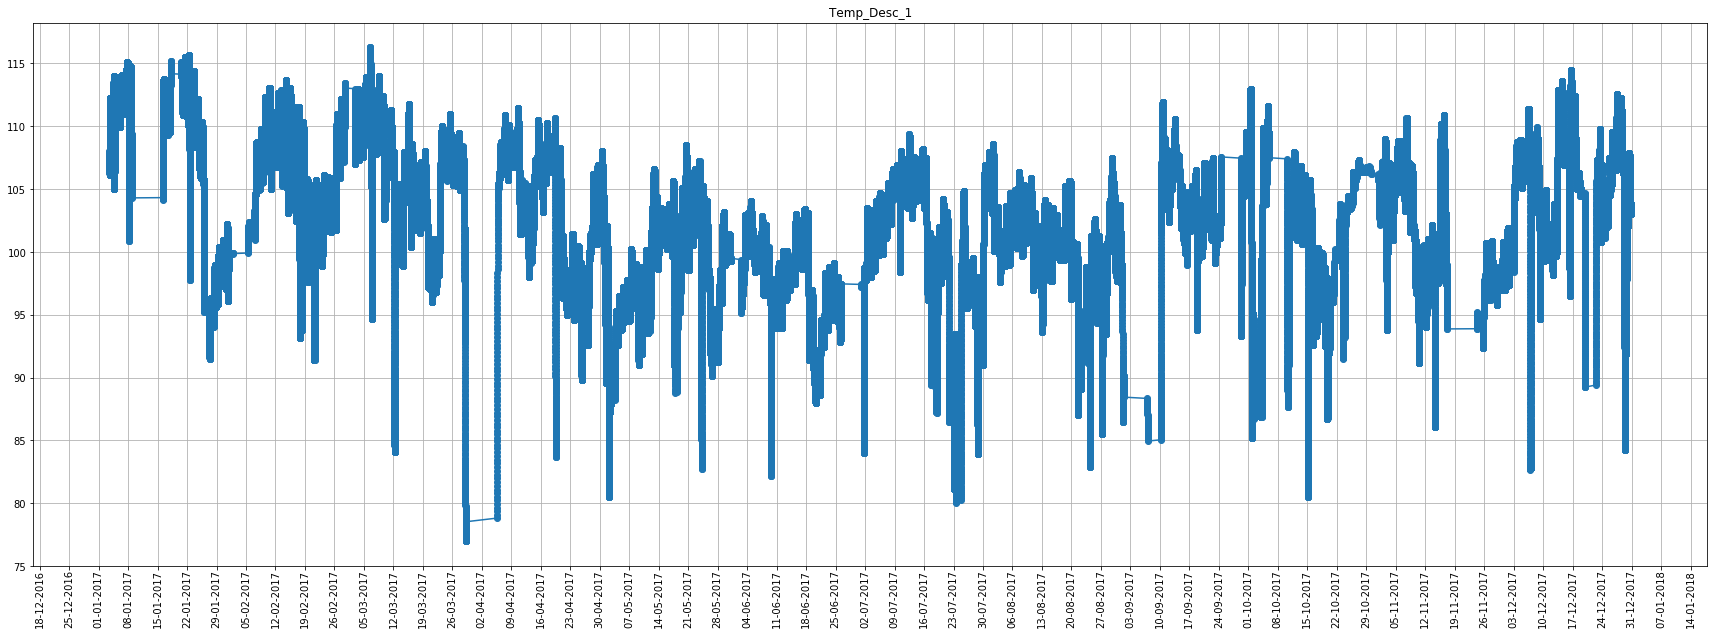

2
(382798, 1)


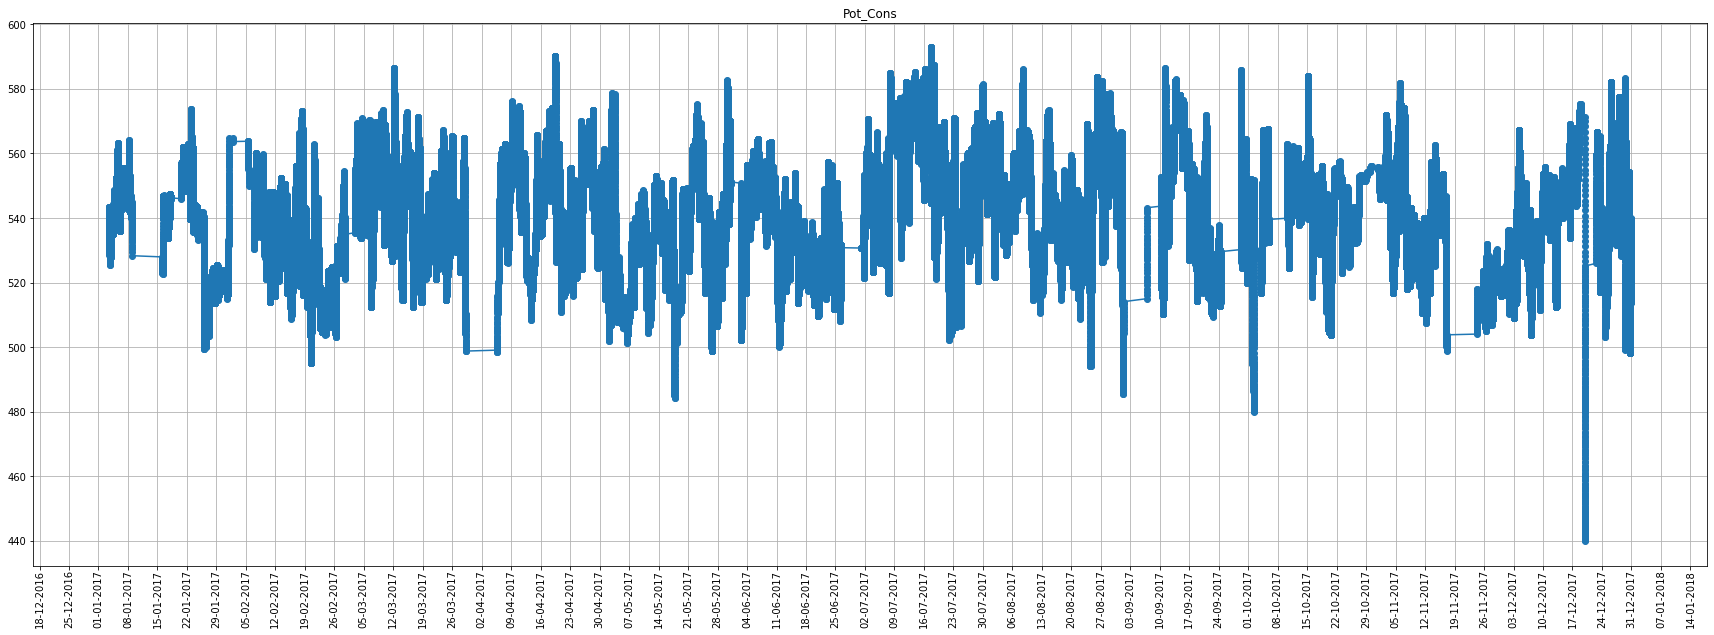

3
(382798, 1)


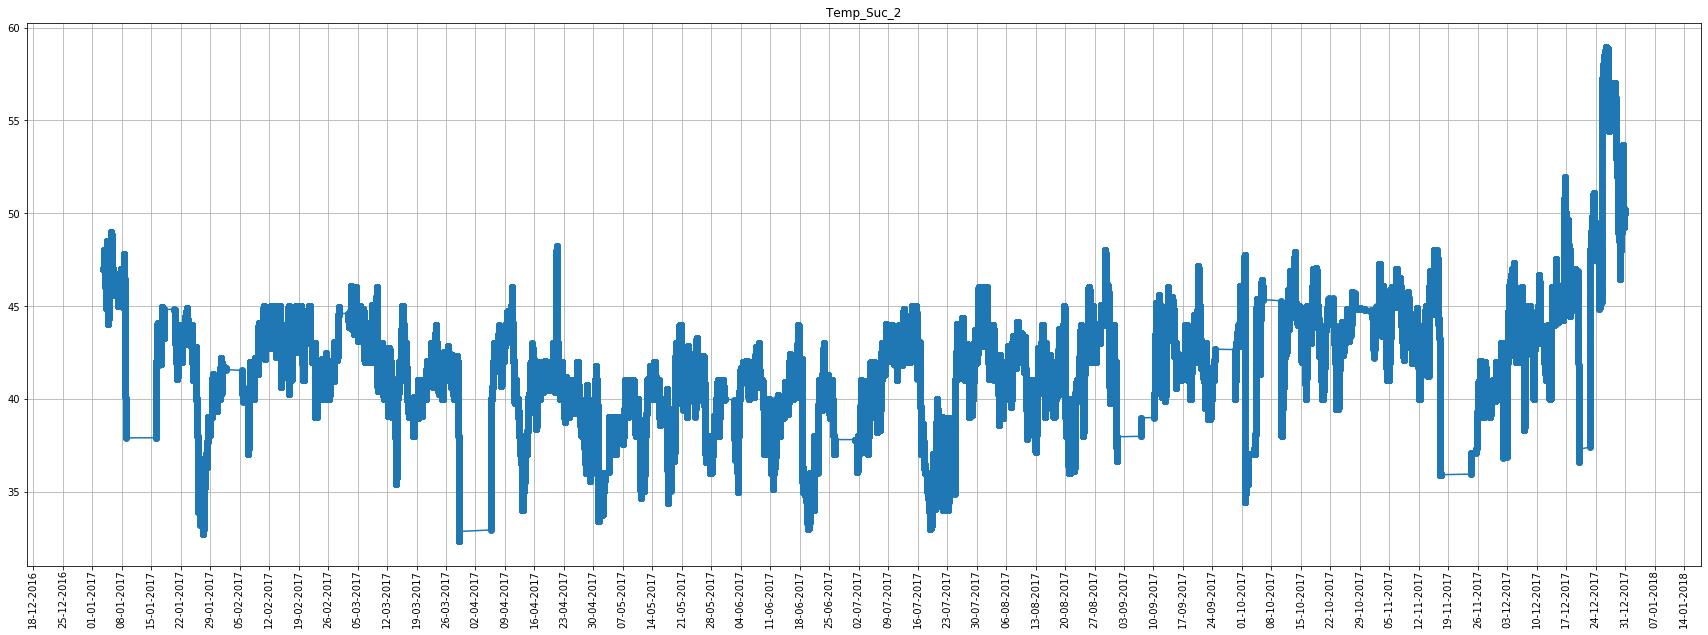

4
(382798, 1)


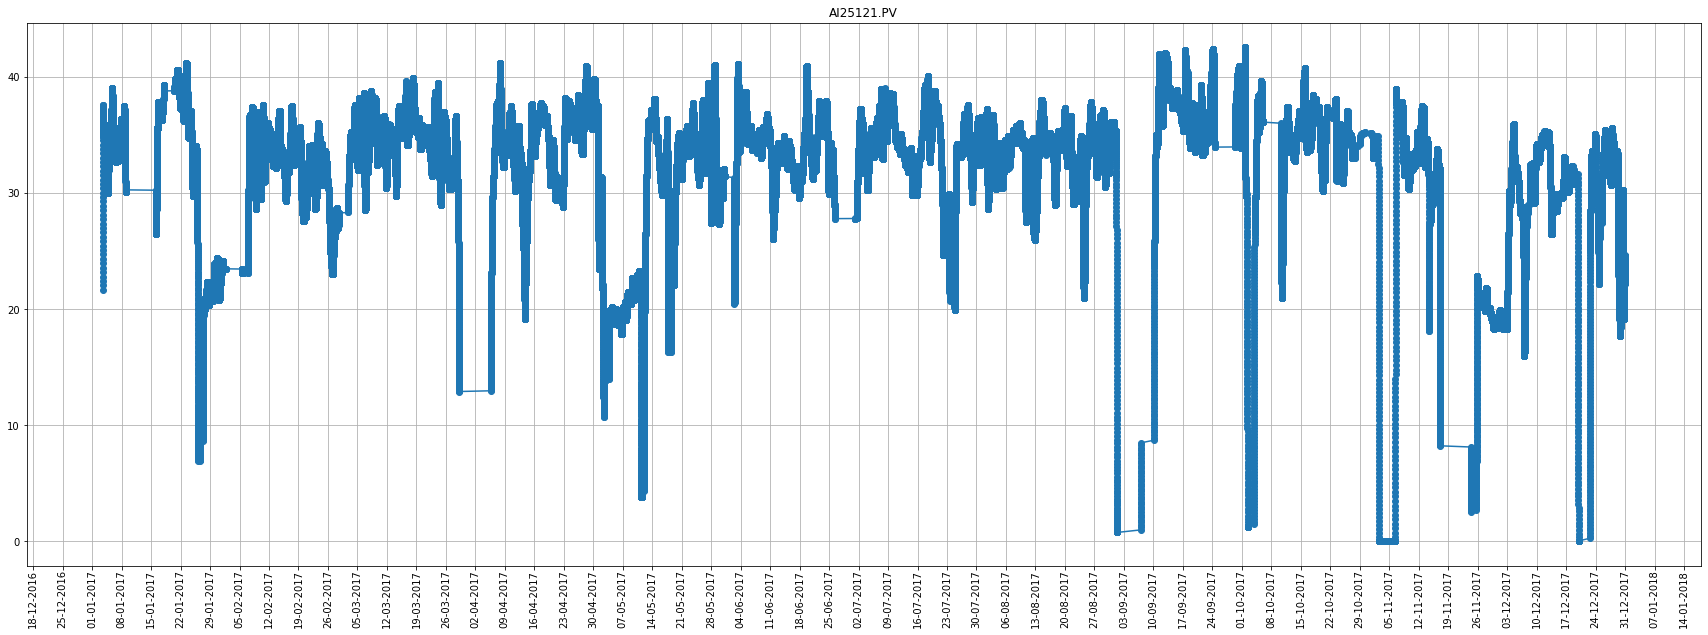

5
(382798, 1)


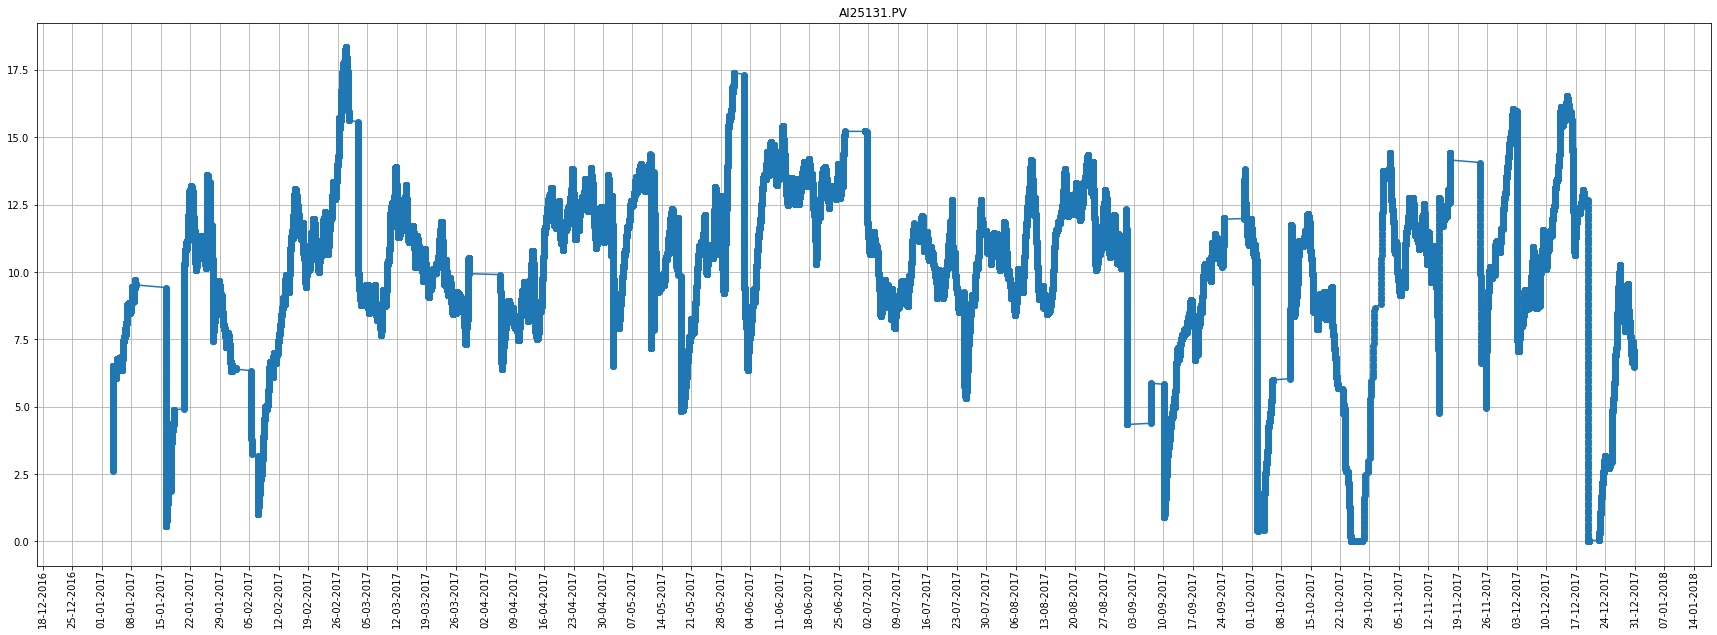

6
(382798, 1)


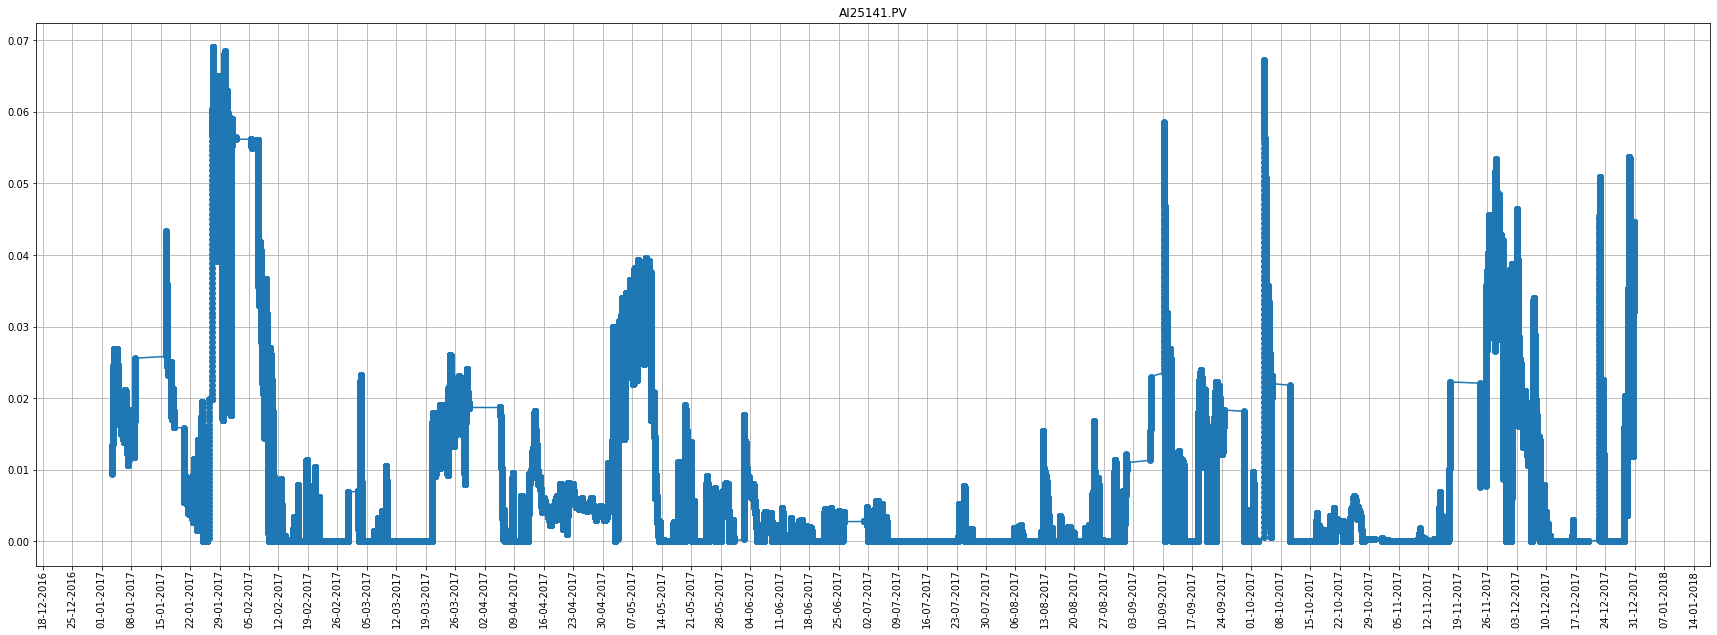

7
(382798, 1)


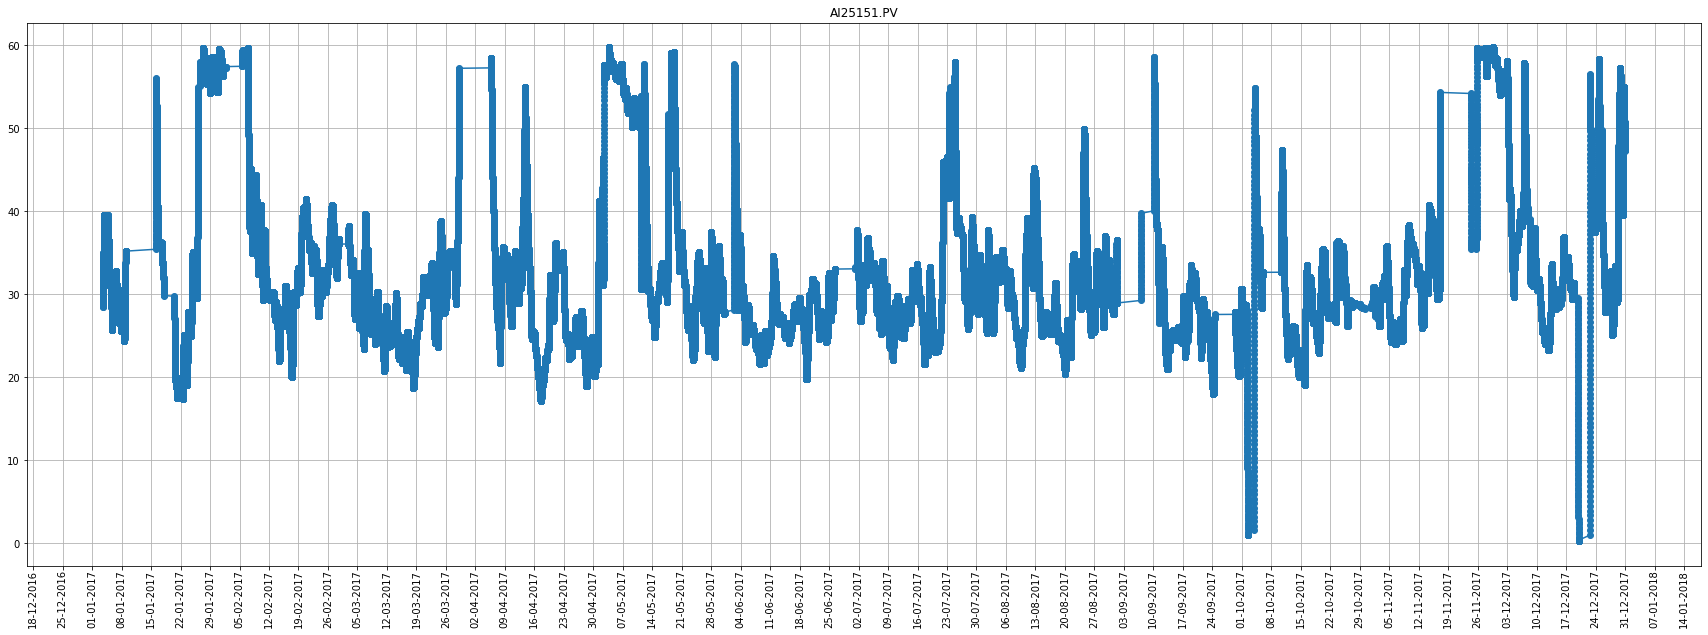

8
(382798, 1)


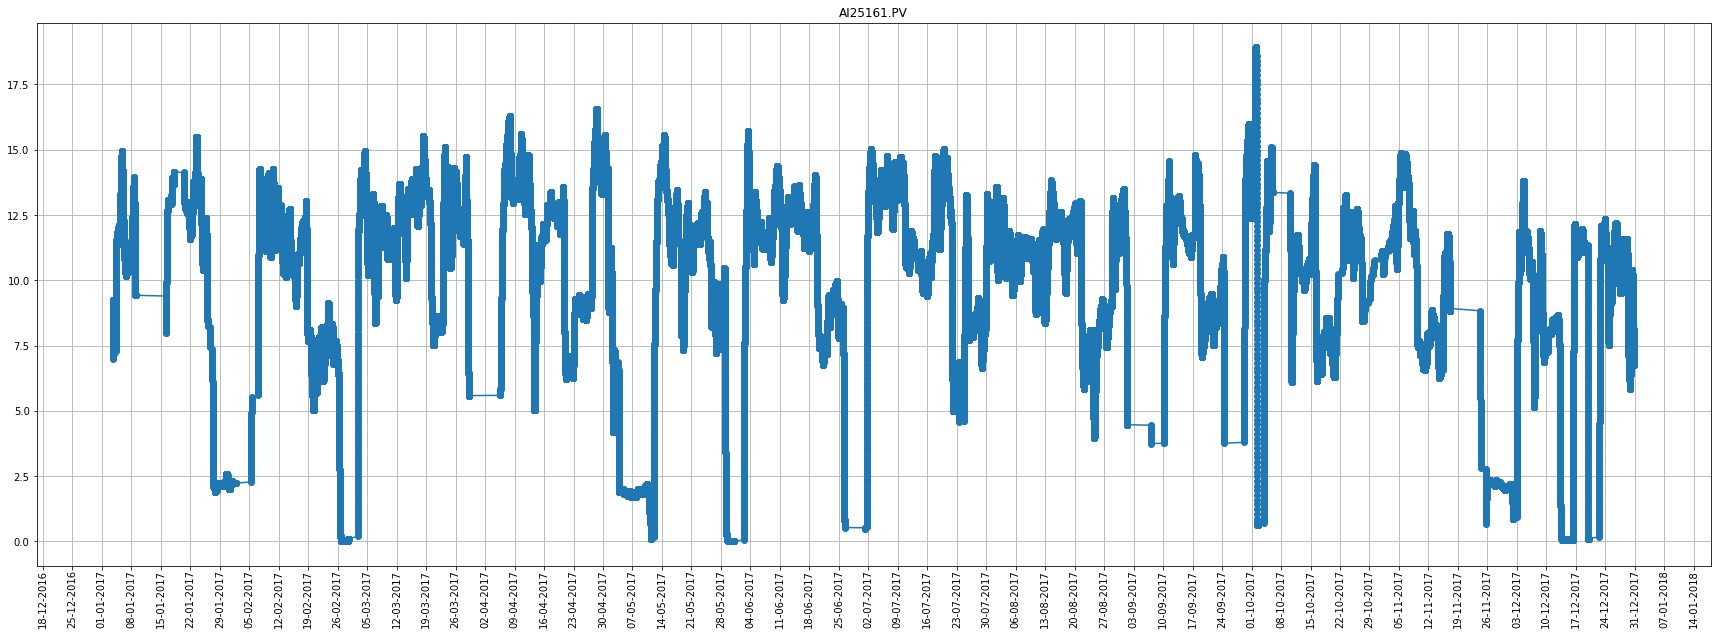

9
(382798, 1)


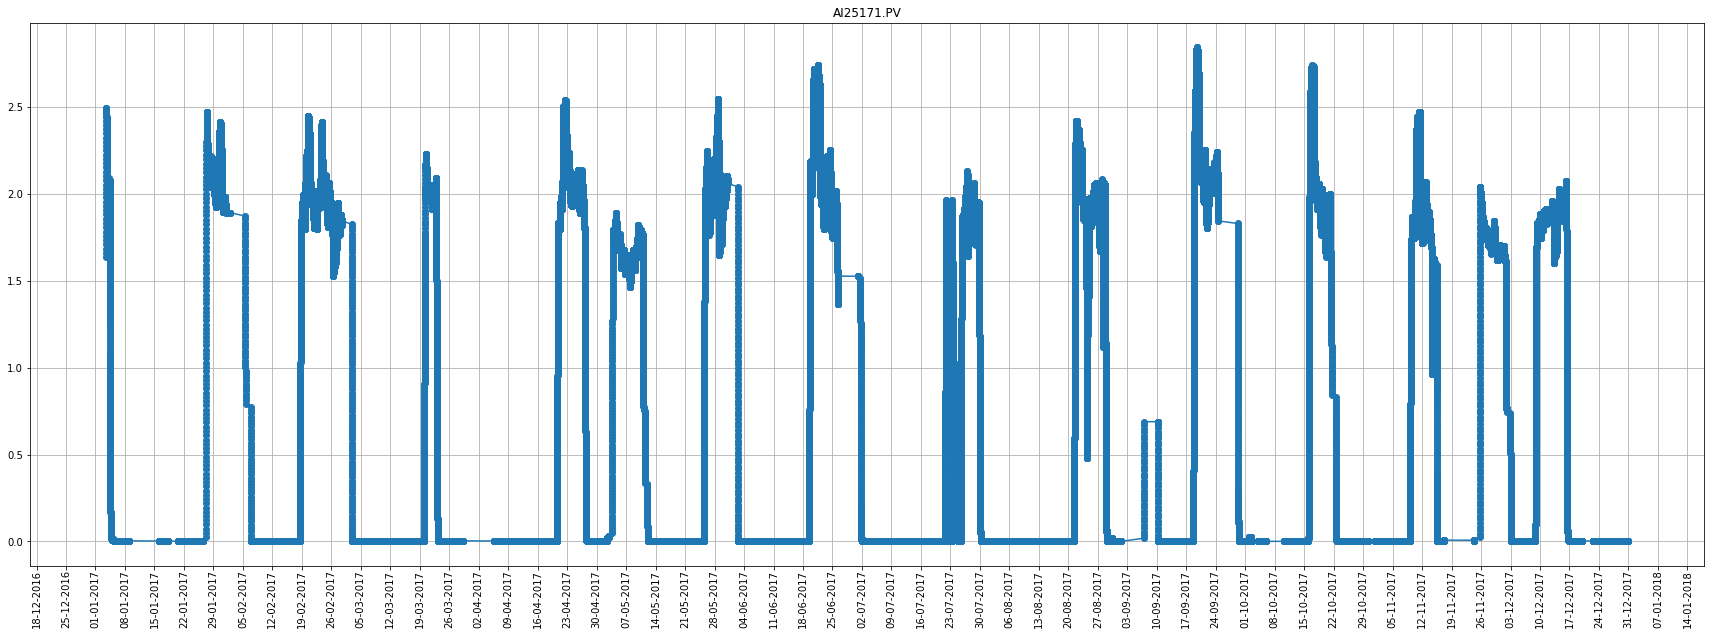

10
(382798, 1)


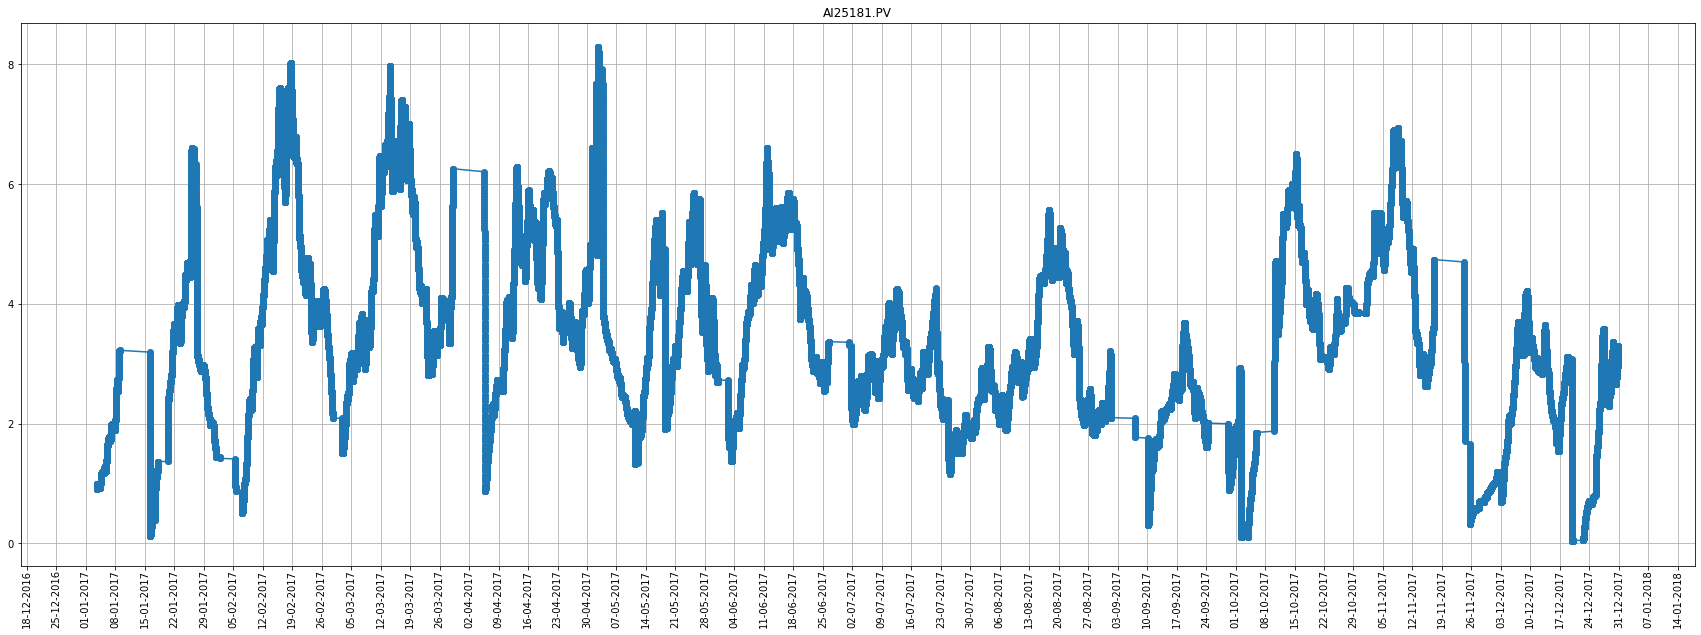

11
(382798, 1)


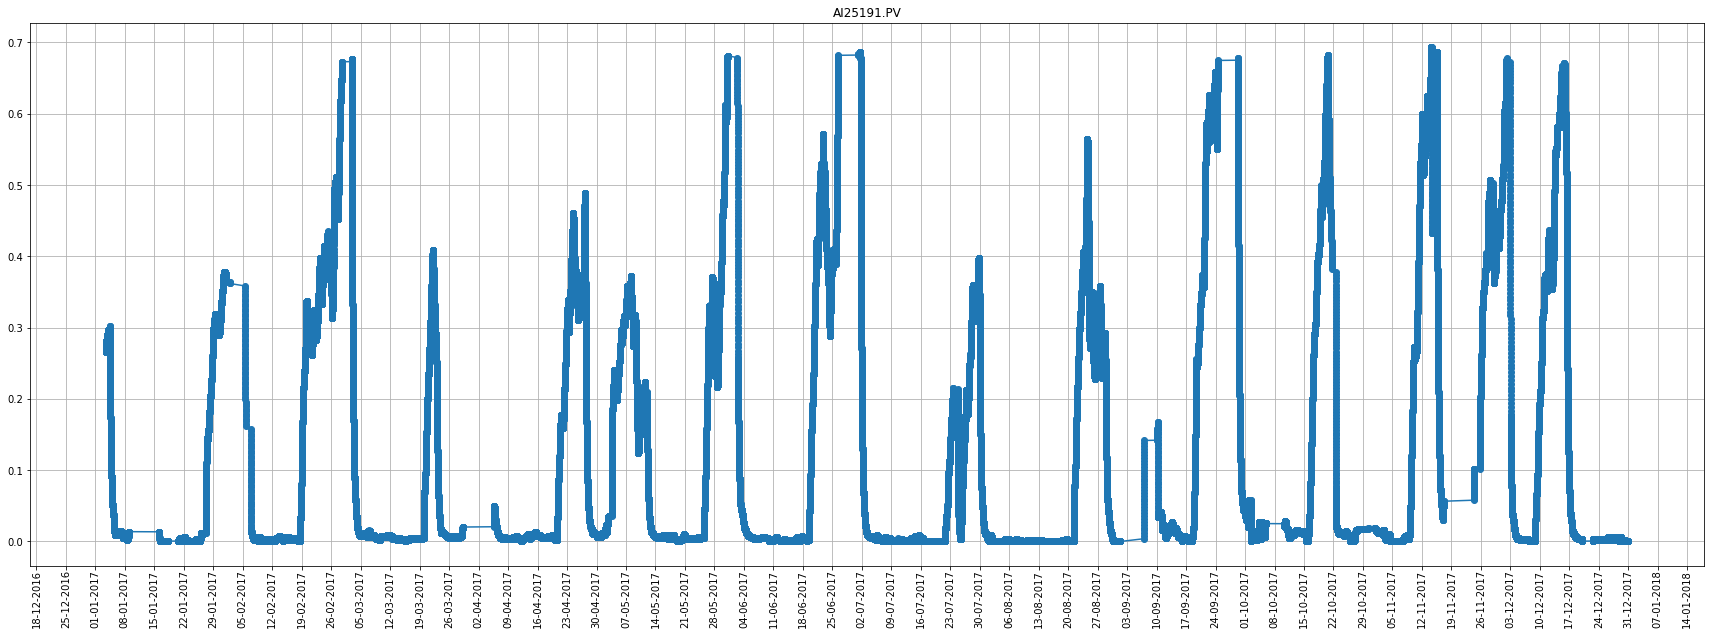

12
(382798, 1)


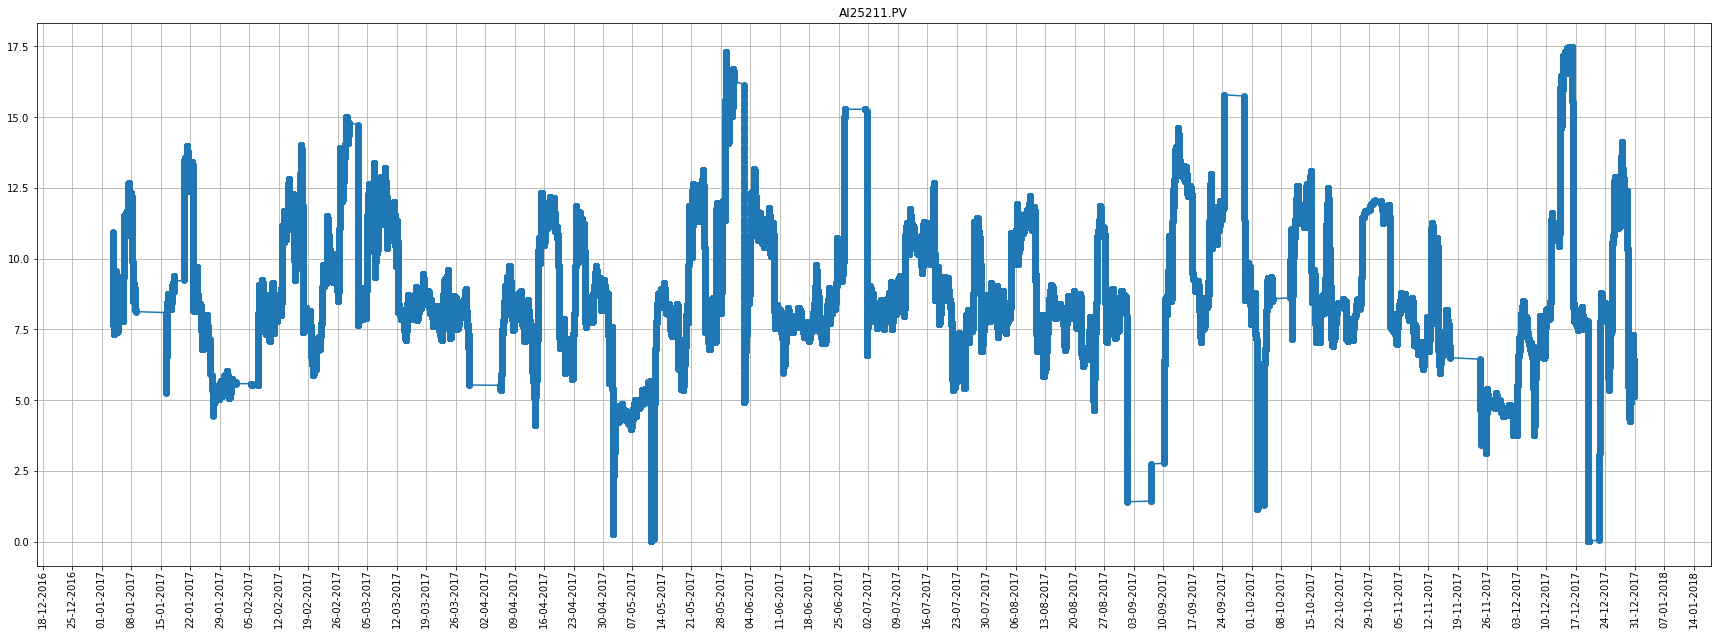

Linear Model
(382798, 2)


C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


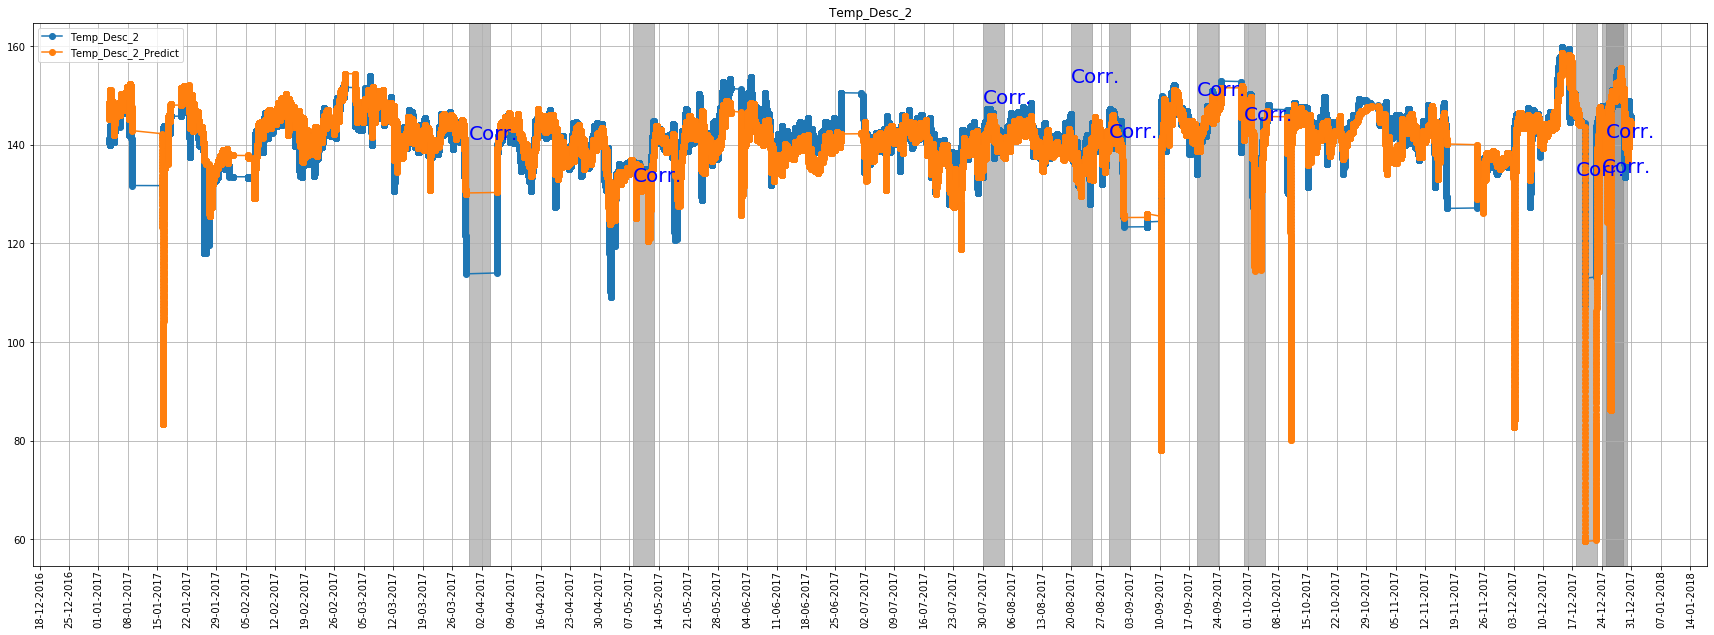

(382798, 1)


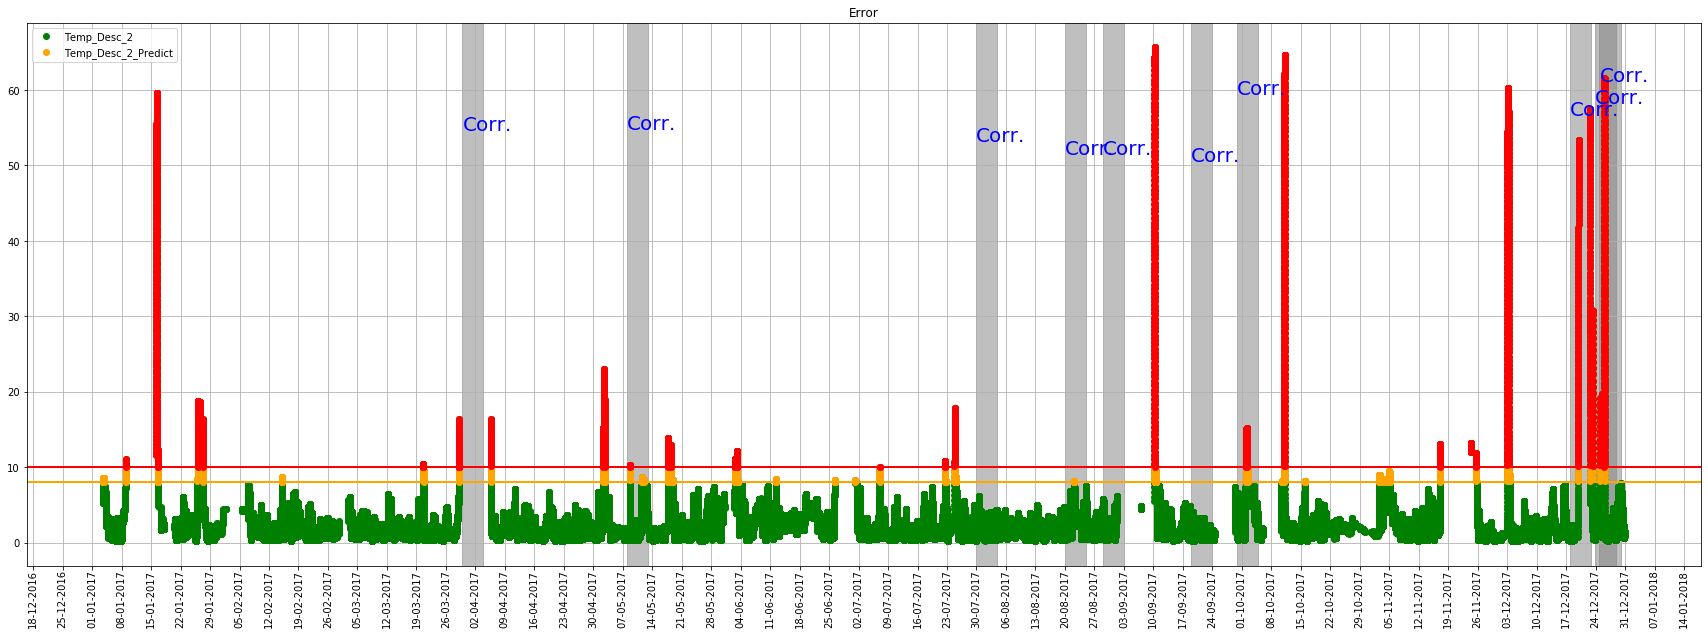

In [27]:
start_date = '01/01/2017 00:00'
end_date = '12/31/2017 00:00'
rolling_time = [100]
days_interval = 7
all_fails = corr

for i in range(0,len(entrada)):
    print(i)
    plot_variables_rolling_V2(df_test,[entrada[i]],start_date,end_date,rolling_time=rolling_time,days_interval=days_interval);
    
print('Linear Model') 
plot_variables_rolling_V2(df_test,[saida[0],prediction_variable],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails );

plot_variables_rolling_V2(df_test,['Error'],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails,trasholds=[8.0,10.0],absolute=True);


#### 2018

0
(285806, 1)


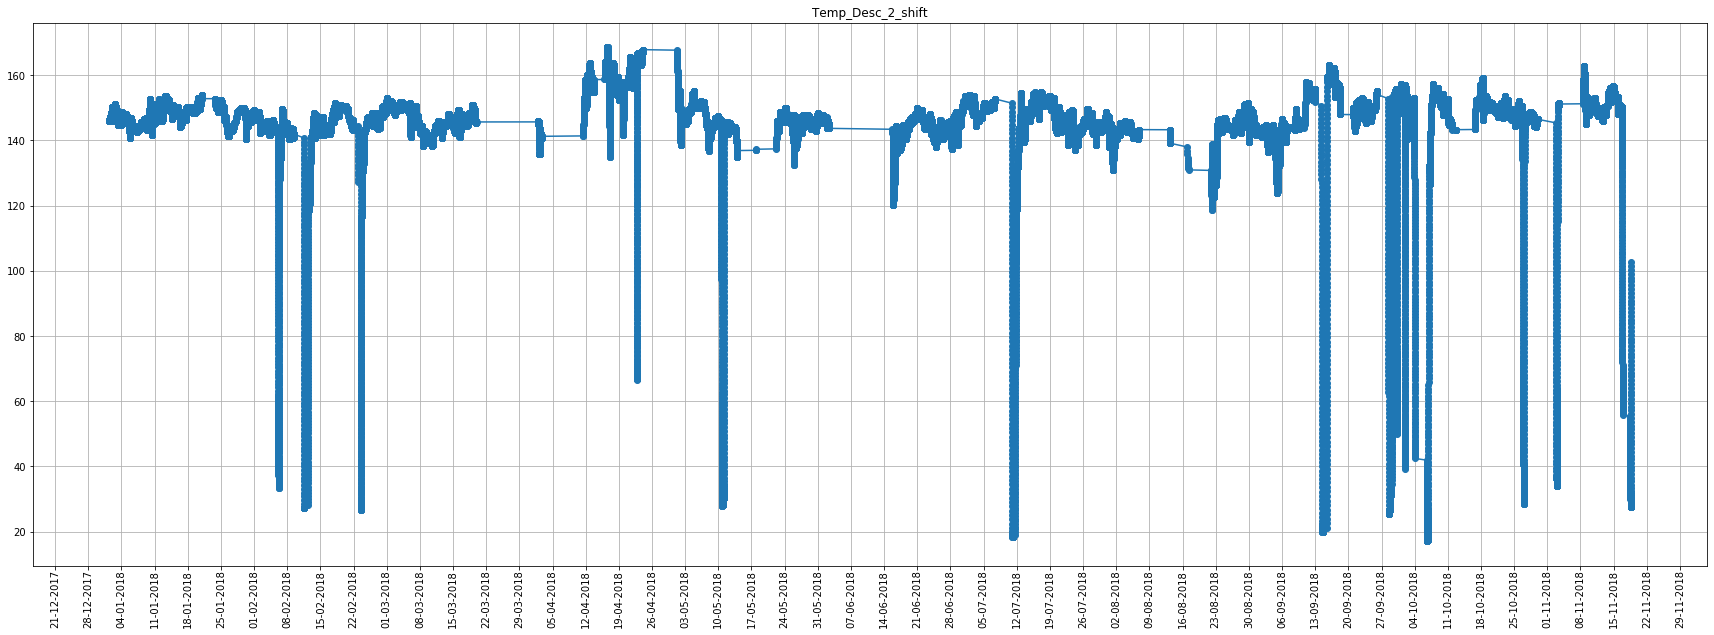

1
(285806, 1)


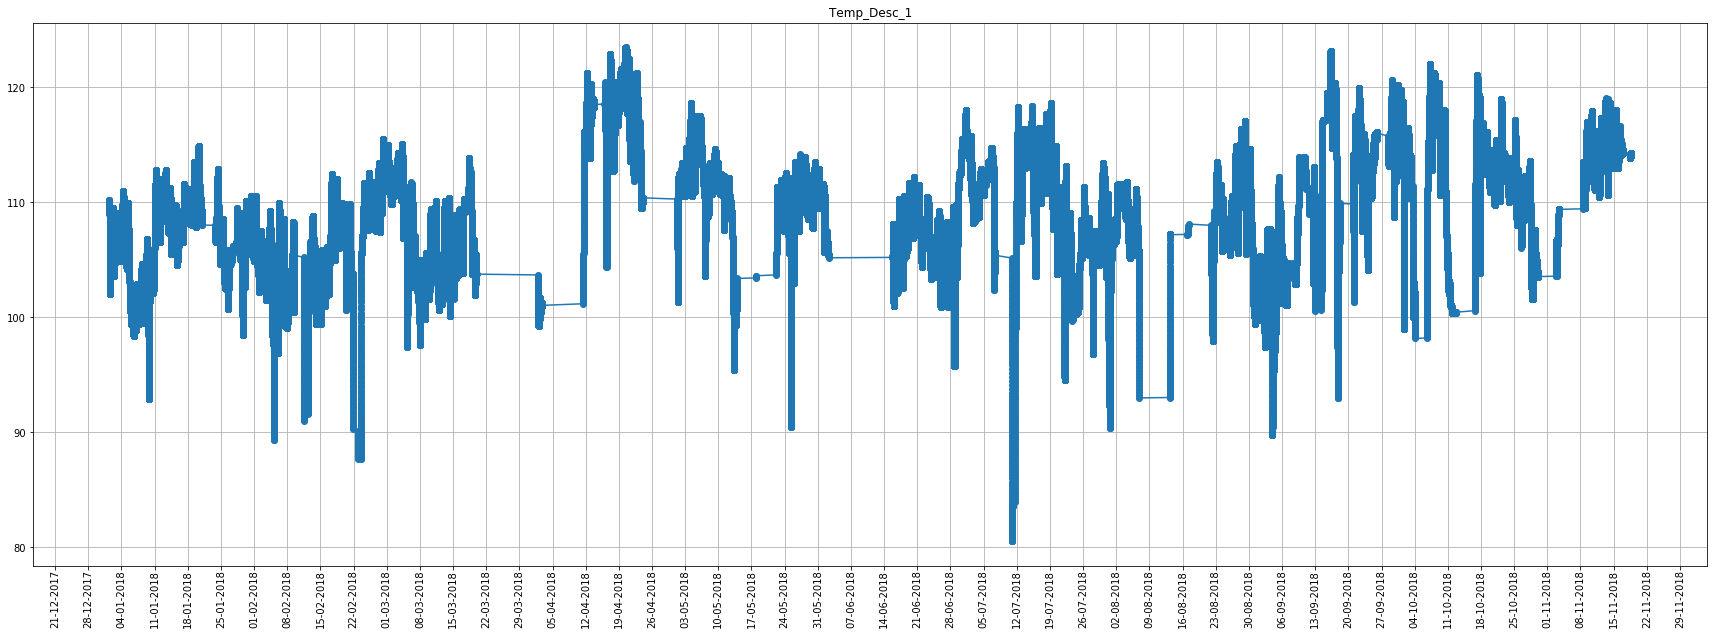

2
(285806, 1)


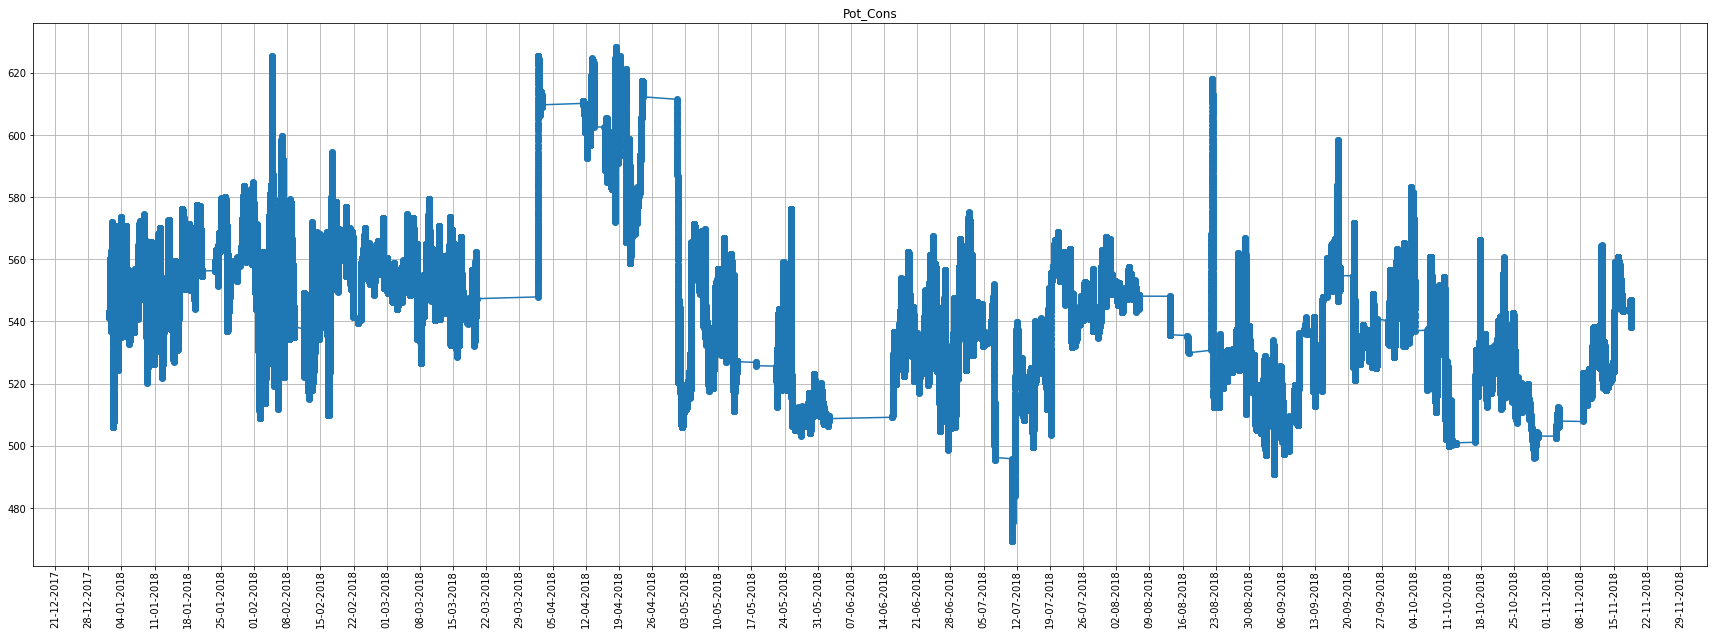

3
(285806, 1)


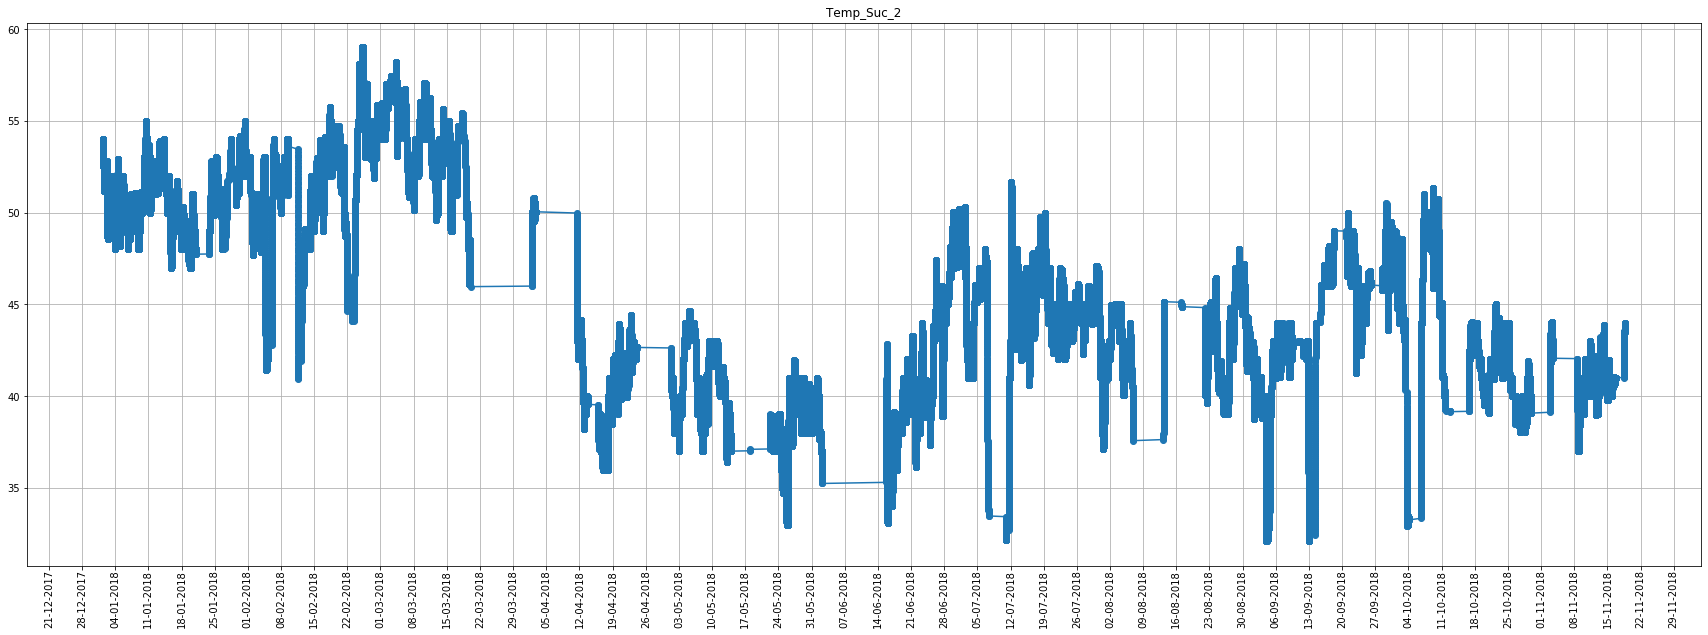

4
(285806, 1)


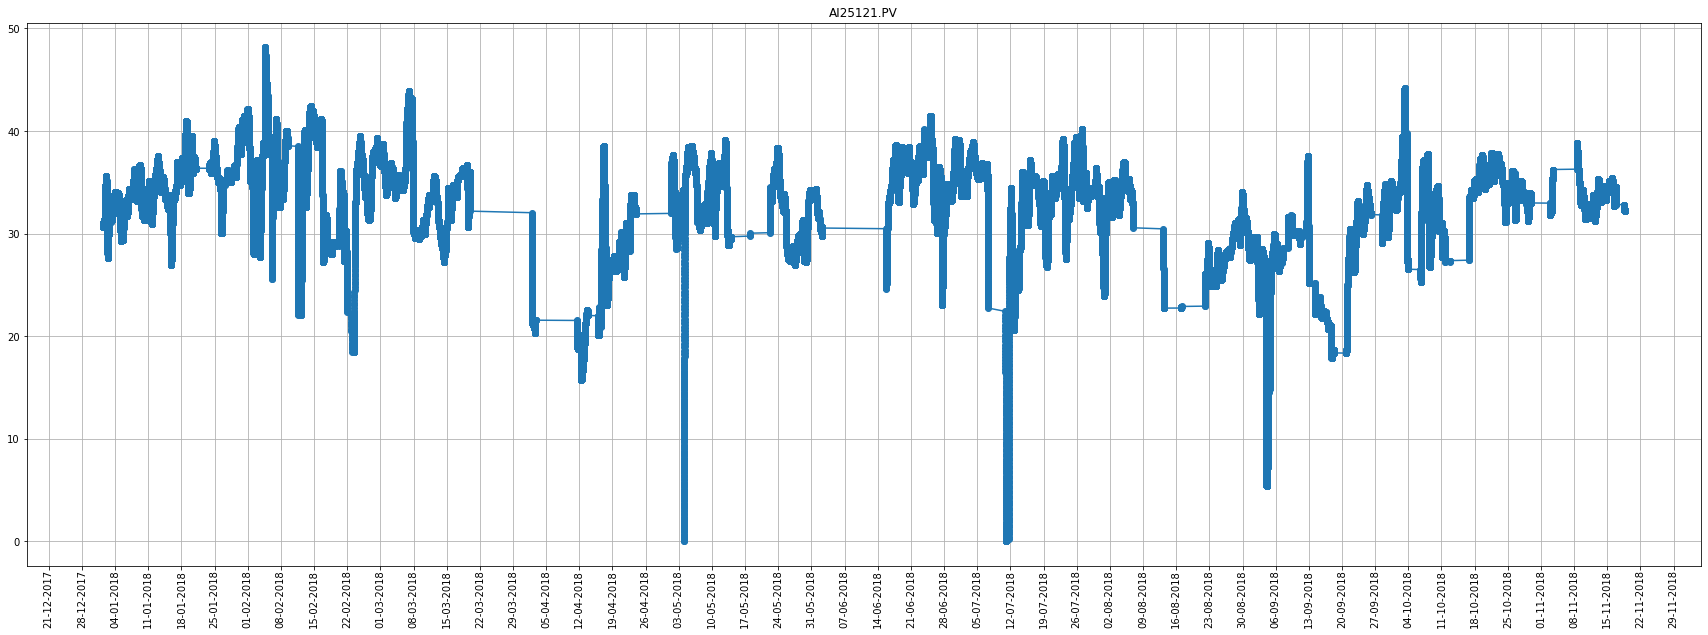

5
(285806, 1)


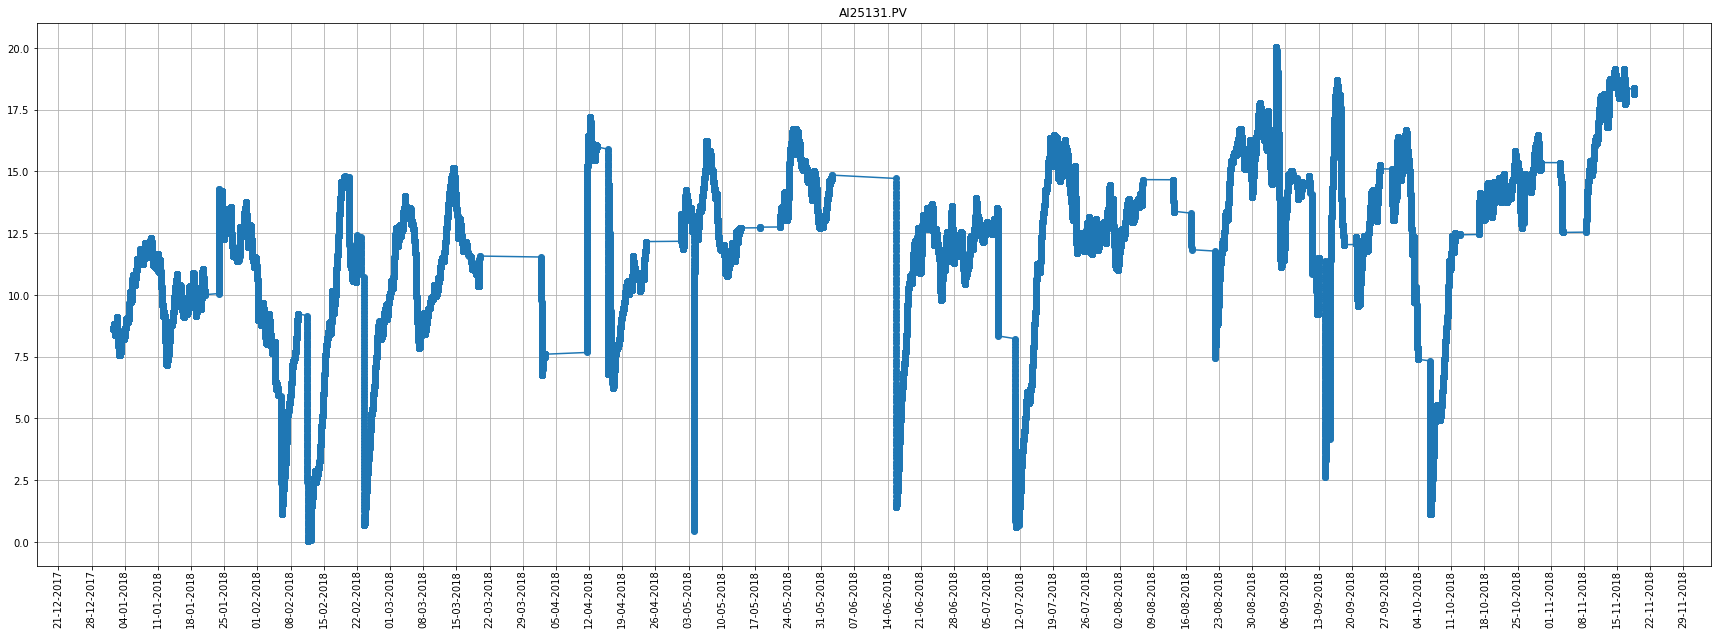

6
(285806, 1)


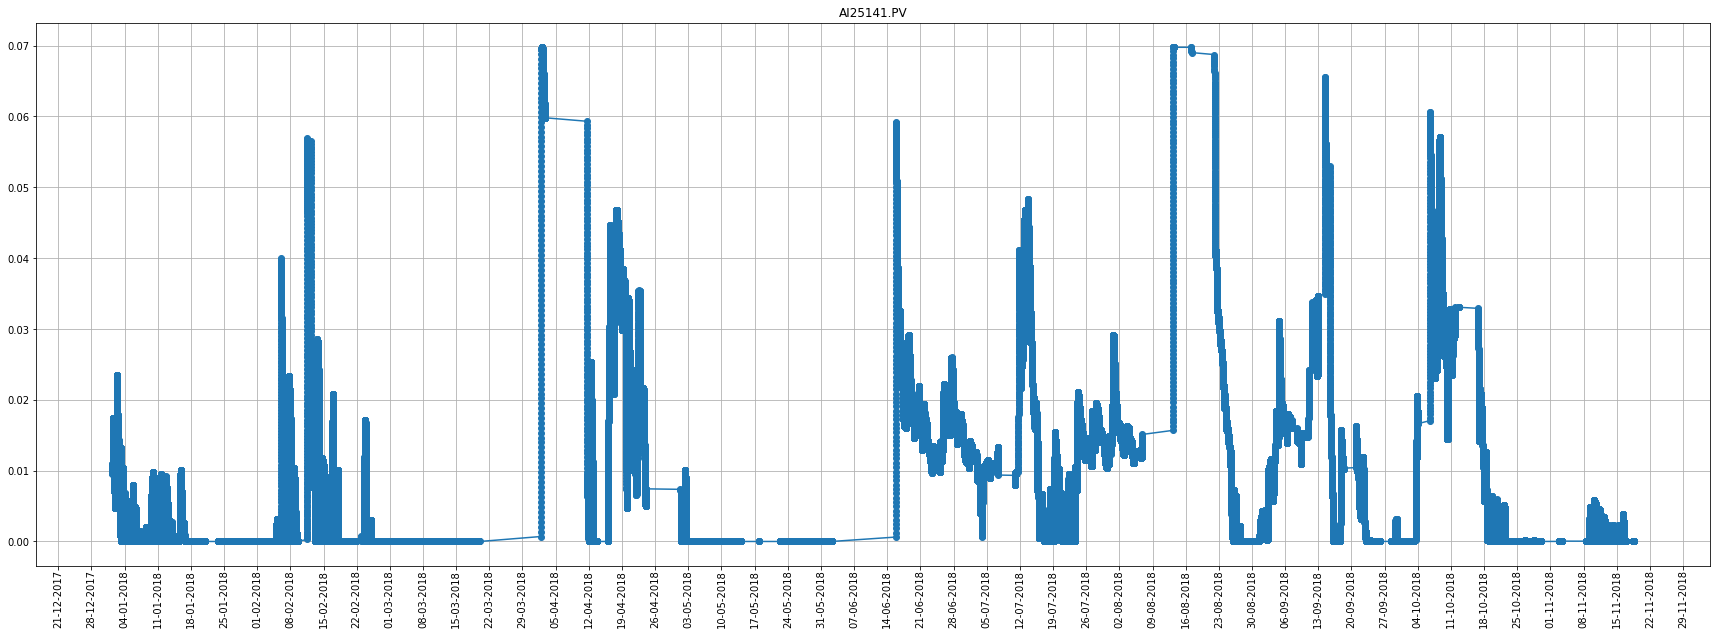

7
(285806, 1)


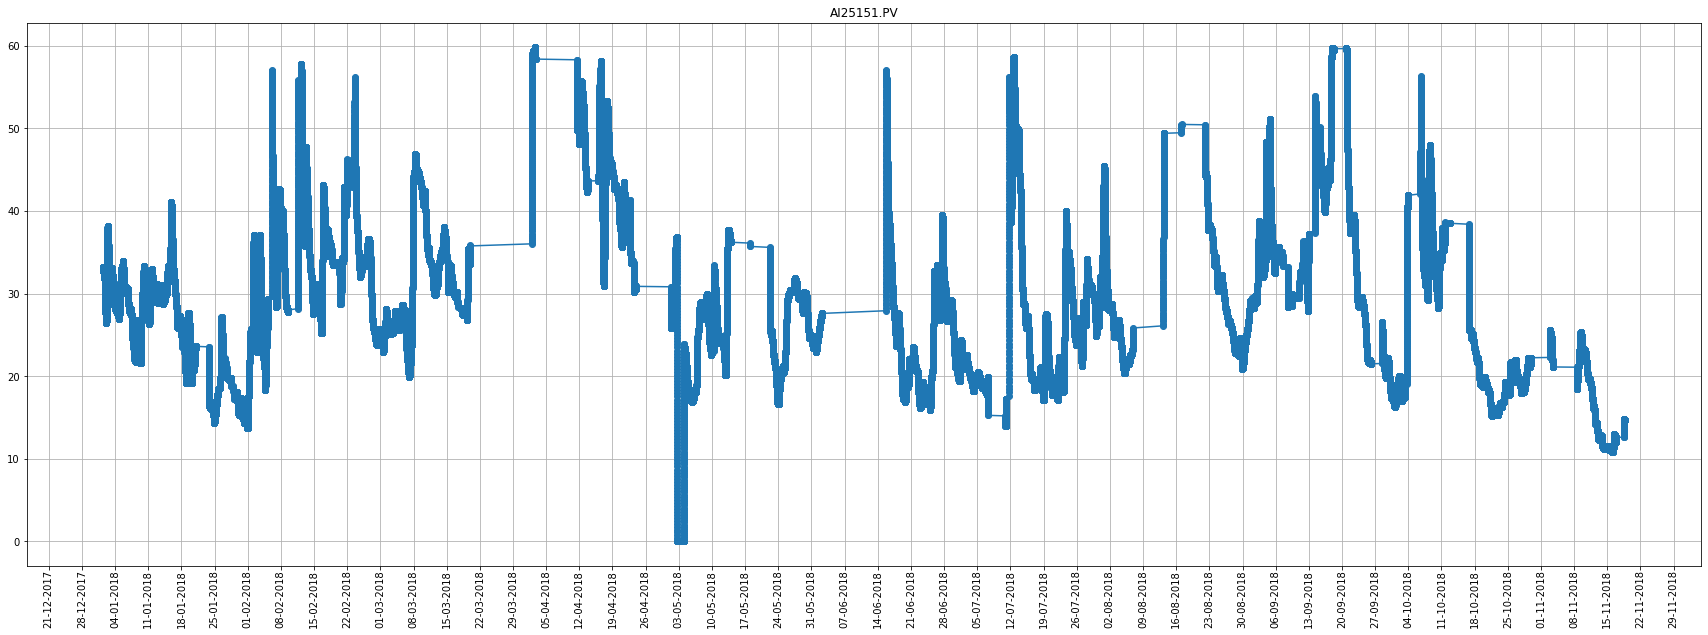

8
(285806, 1)


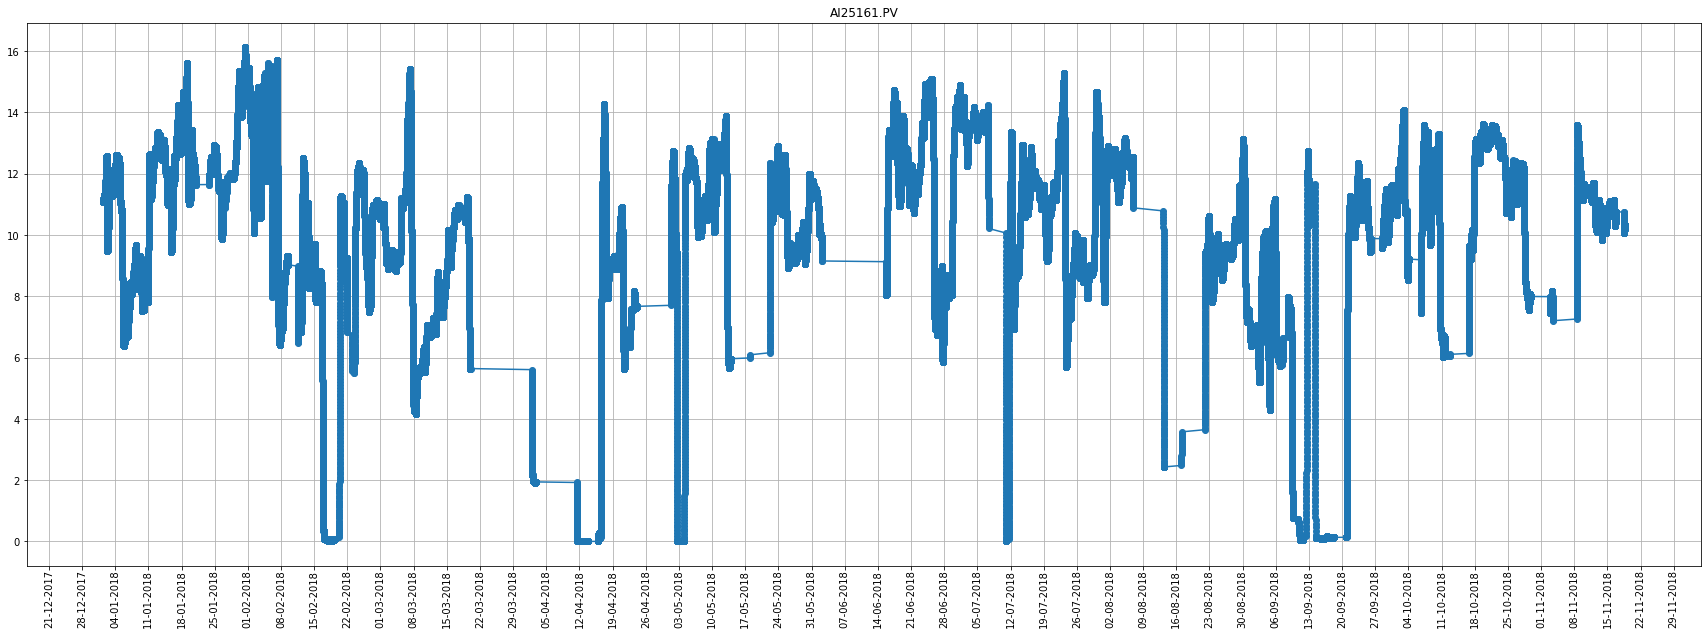

9
(285806, 1)


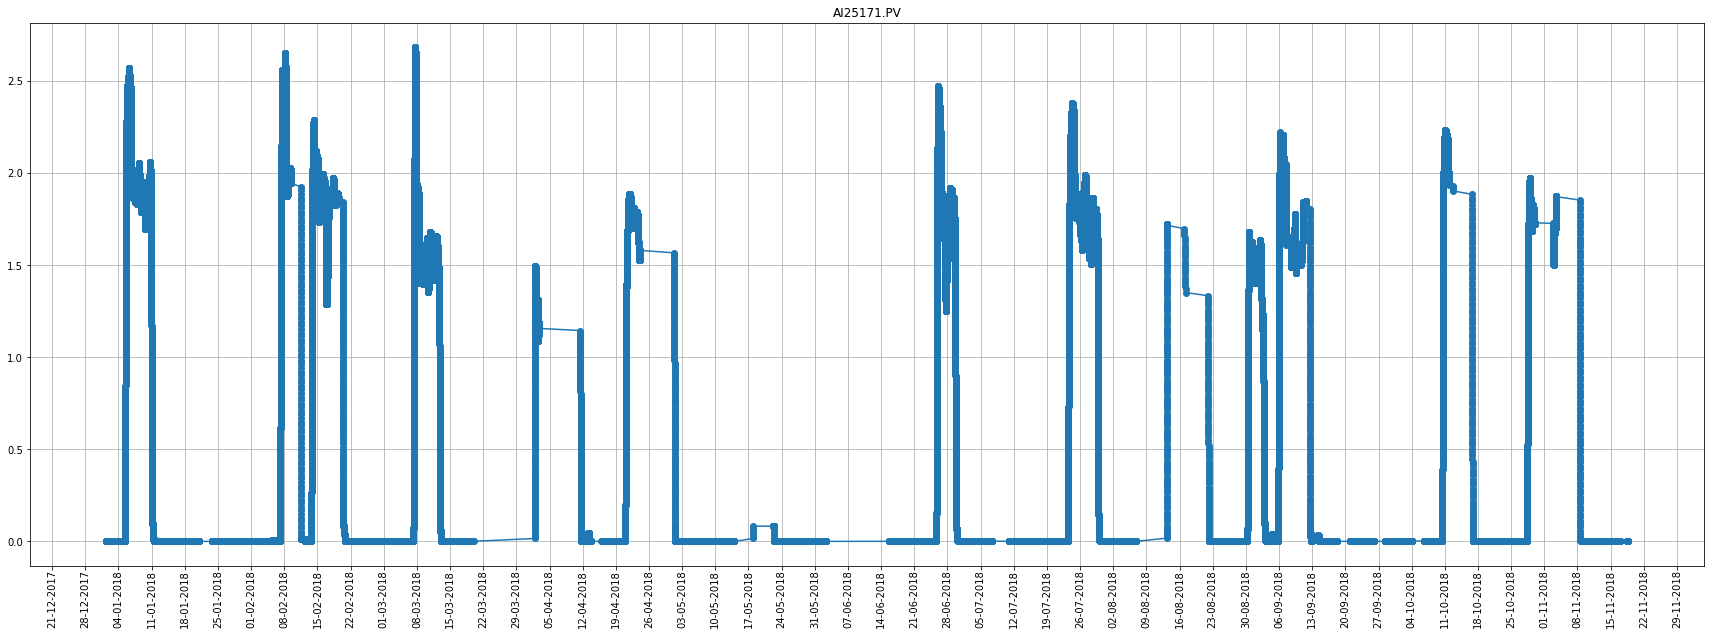

10
(285806, 1)


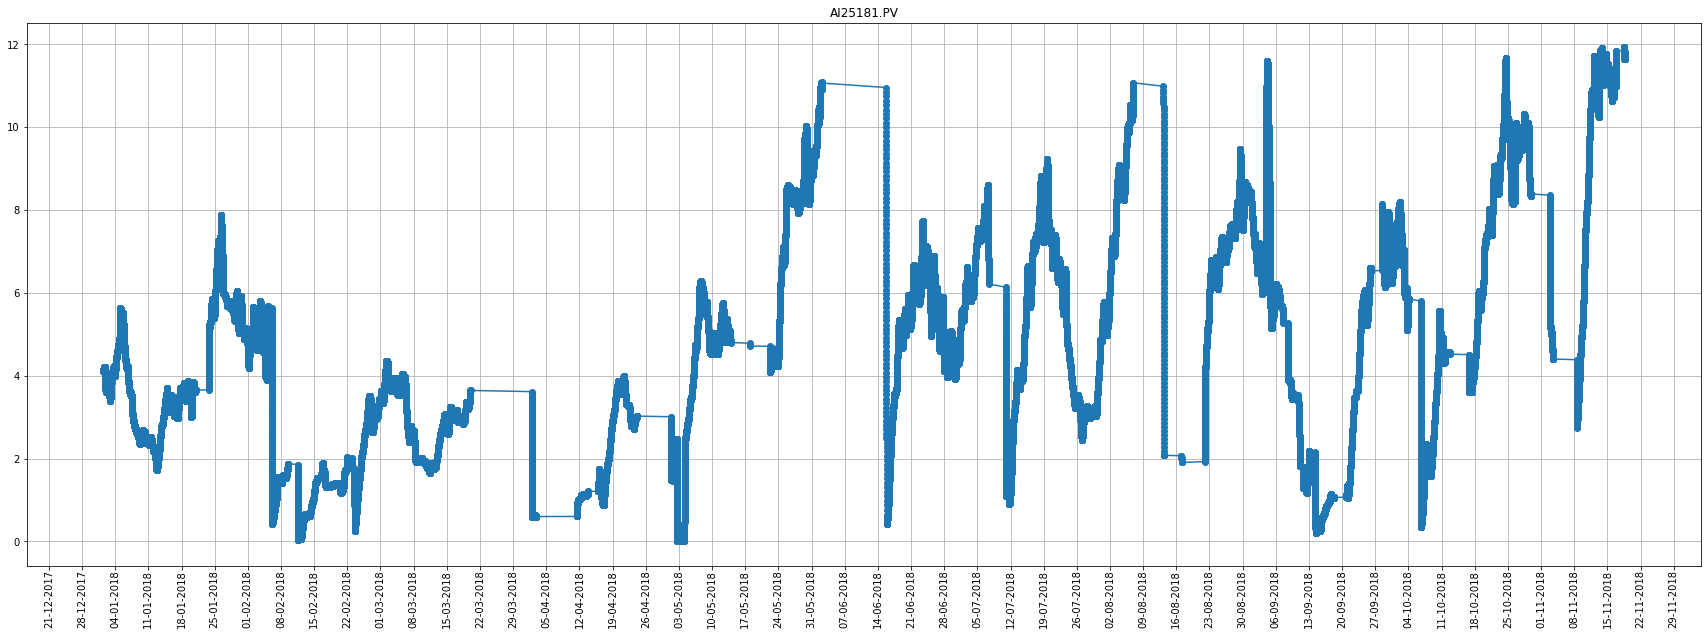

11
(285806, 1)


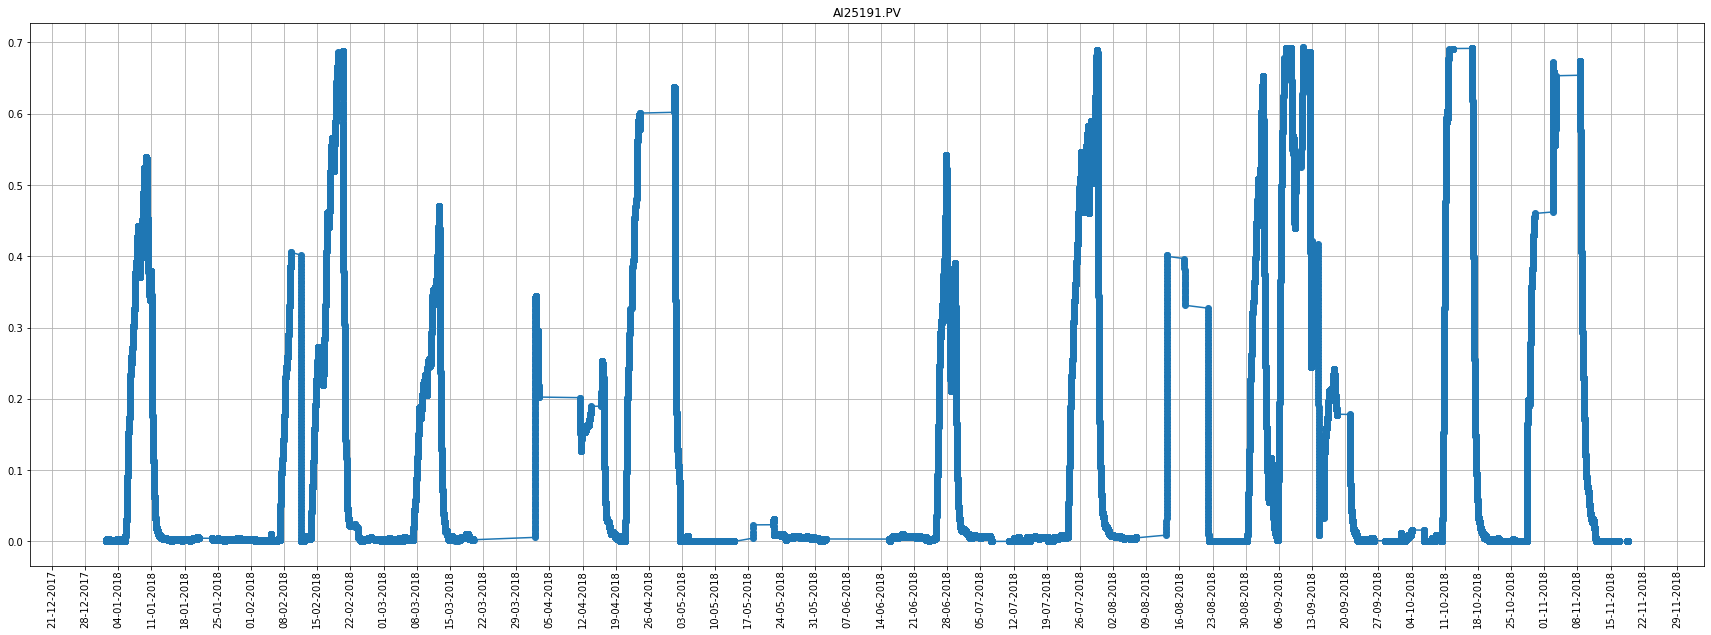

12
(285806, 1)


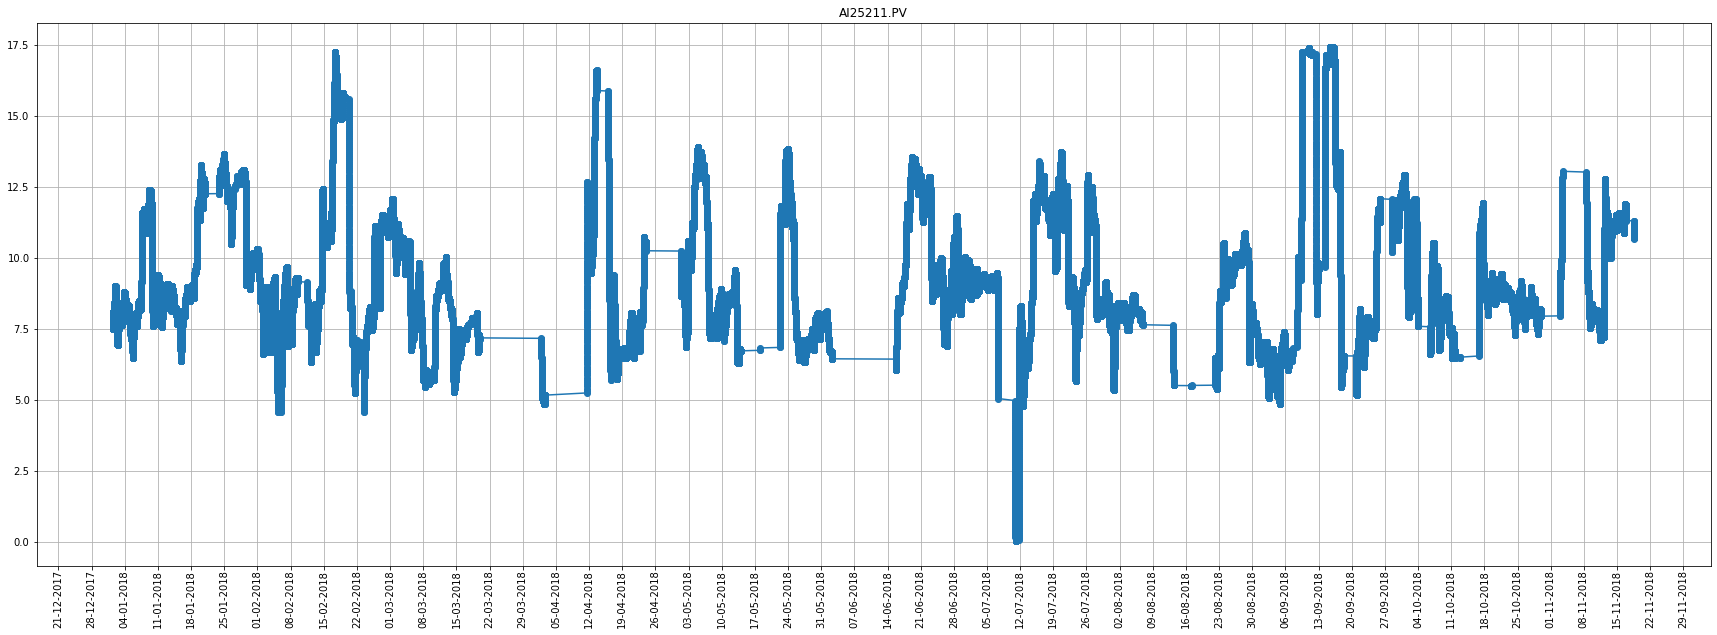

Linear Model
(285806, 2)


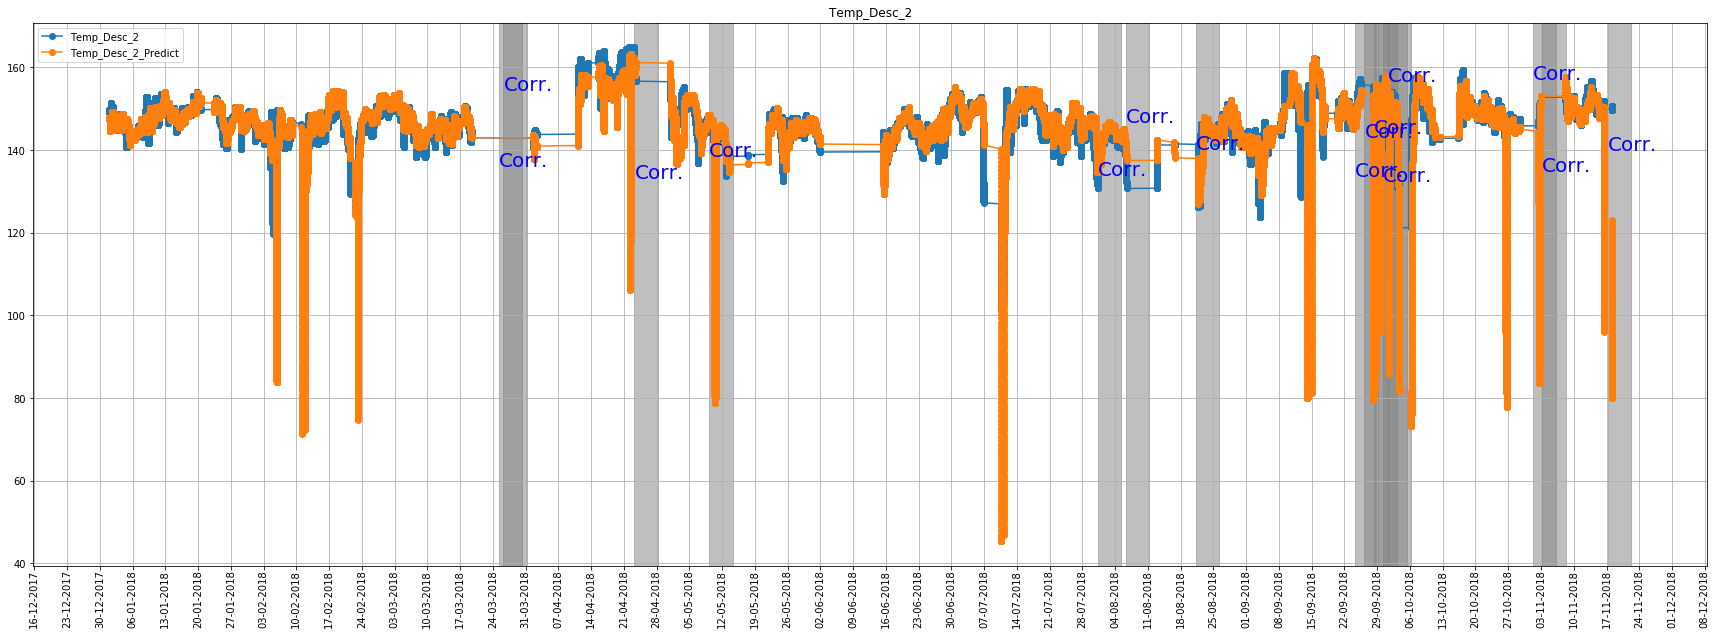

(285806, 1)


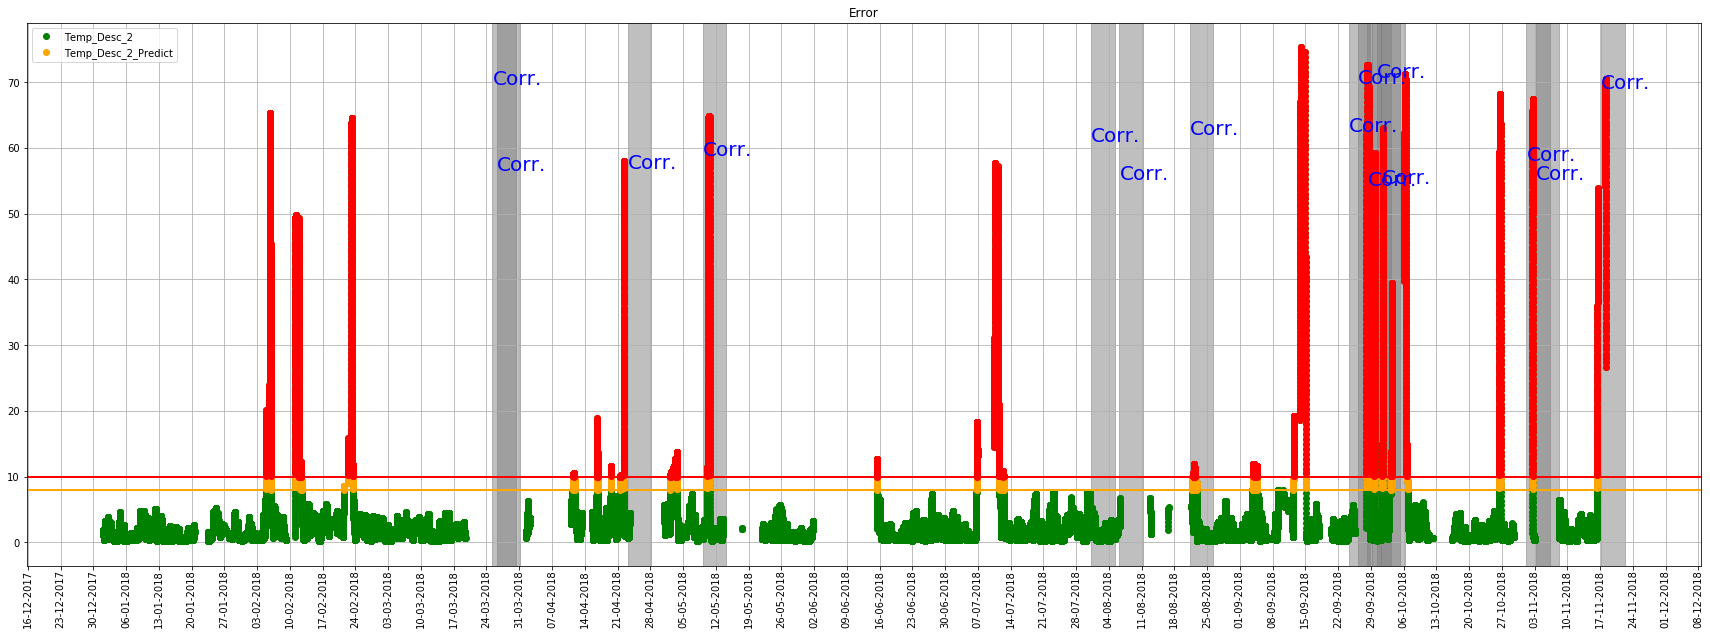

In [28]:
start_date = '01/01/2018 00:00'
end_date = '12/31/2018 00:00'
rolling_time = [100]
days_interval = 7
all_fails = corr

for i in range(0,len(entrada)):
    print(i)
    plot_variables_rolling_V2(df_test,[entrada[i]],start_date,end_date,rolling_time=rolling_time,days_interval=days_interval);
    
print('Linear Model') 
plot_variables_rolling_V2(df_test,[saida[0],prediction_variable],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails );

plot_variables_rolling_V2(df_test,['Error'],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails,trasholds=[8.0,10.0],absolute=True);


#### 2016

0
(187589, 1)


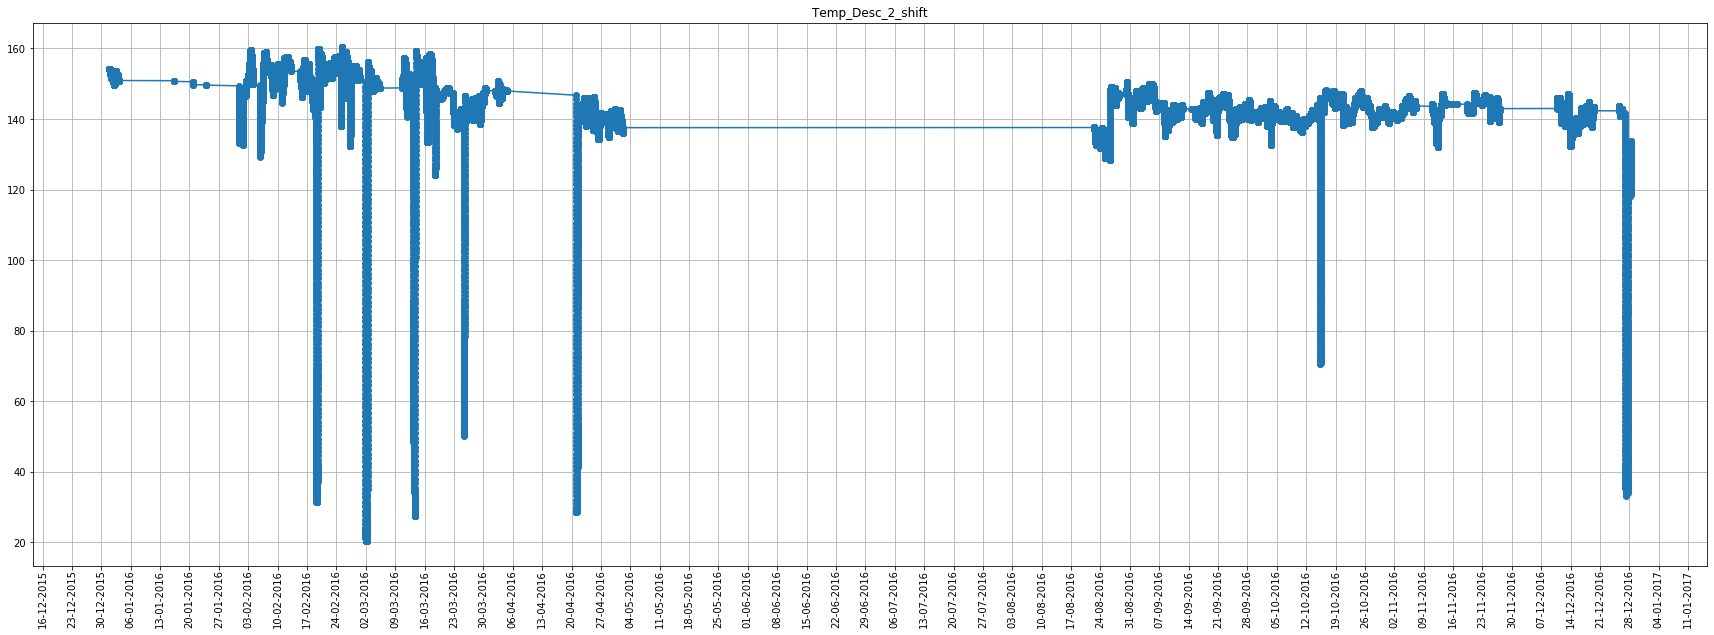

1
(187589, 1)


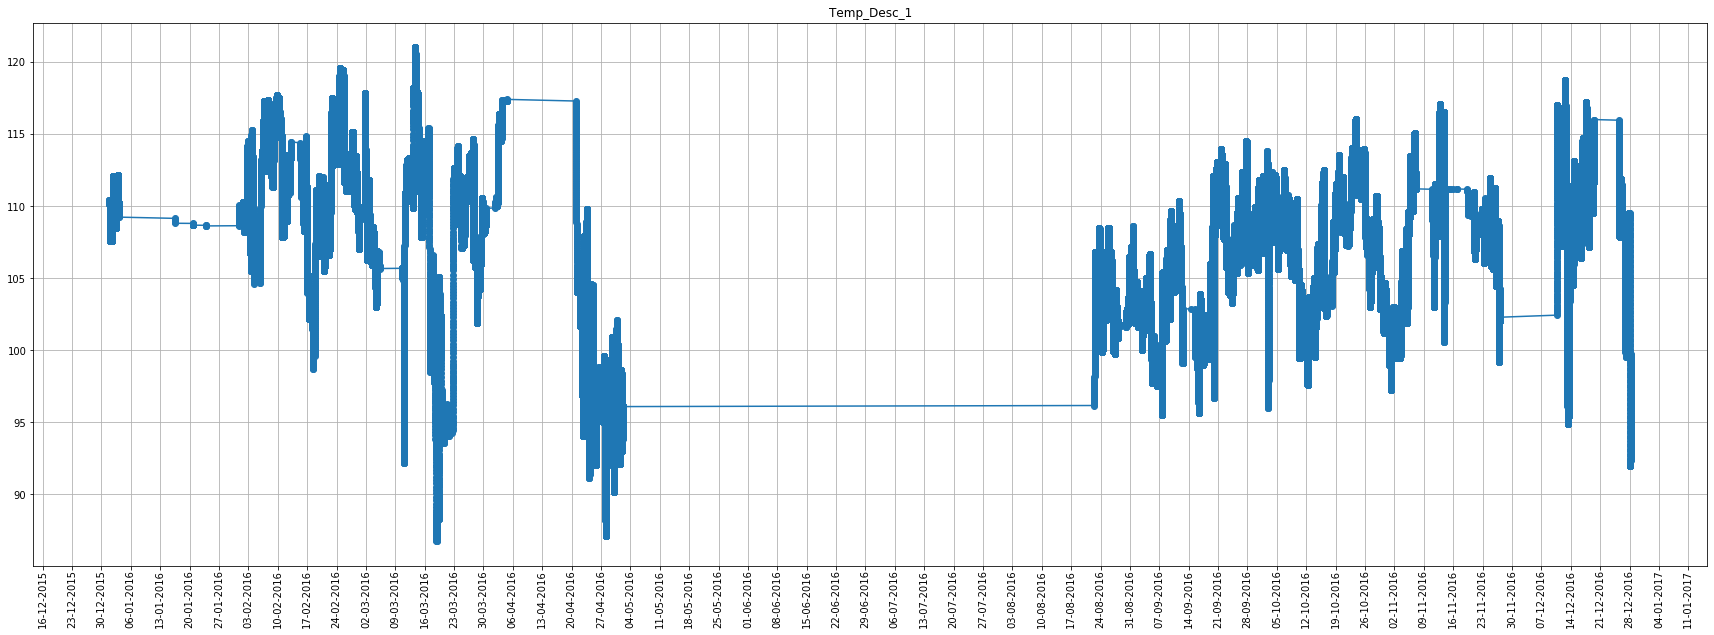

2
(187589, 1)


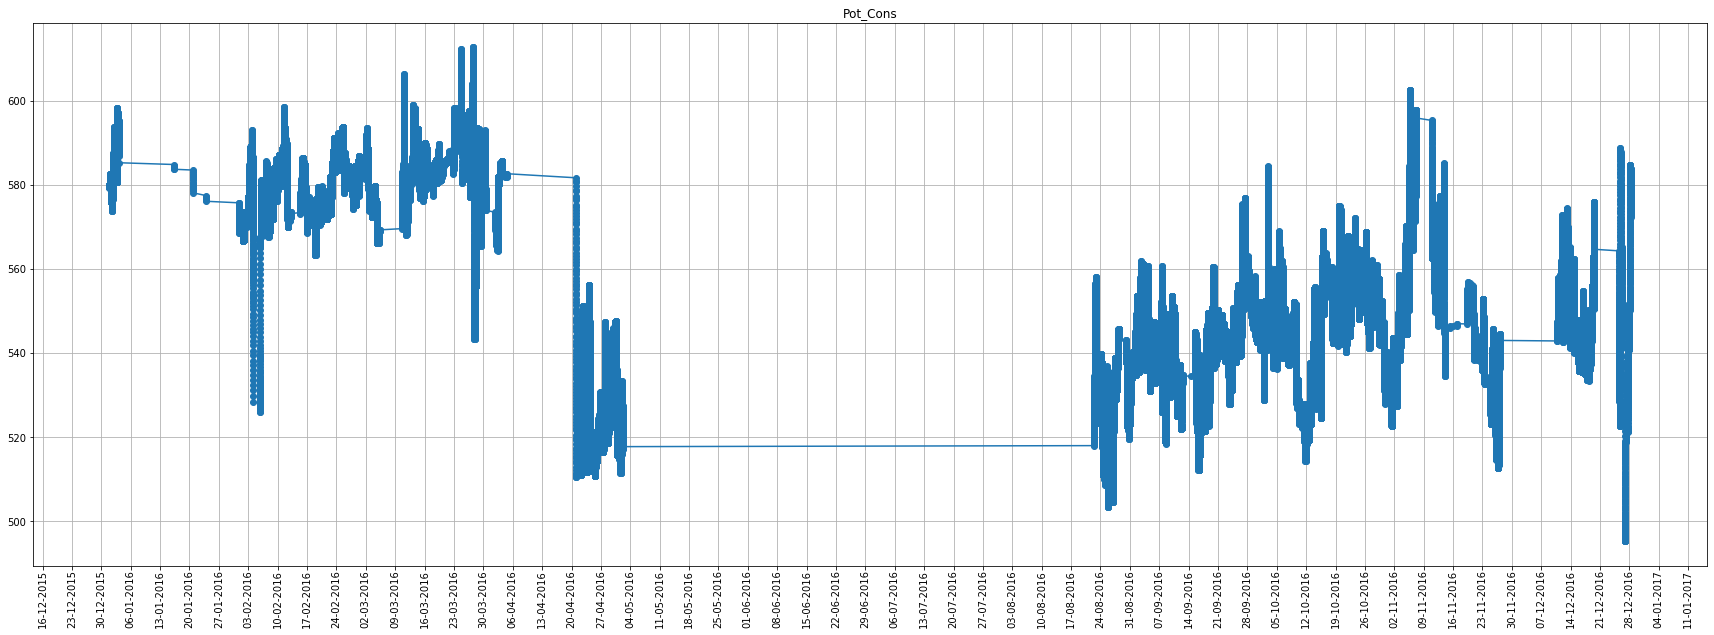

3
(187589, 1)


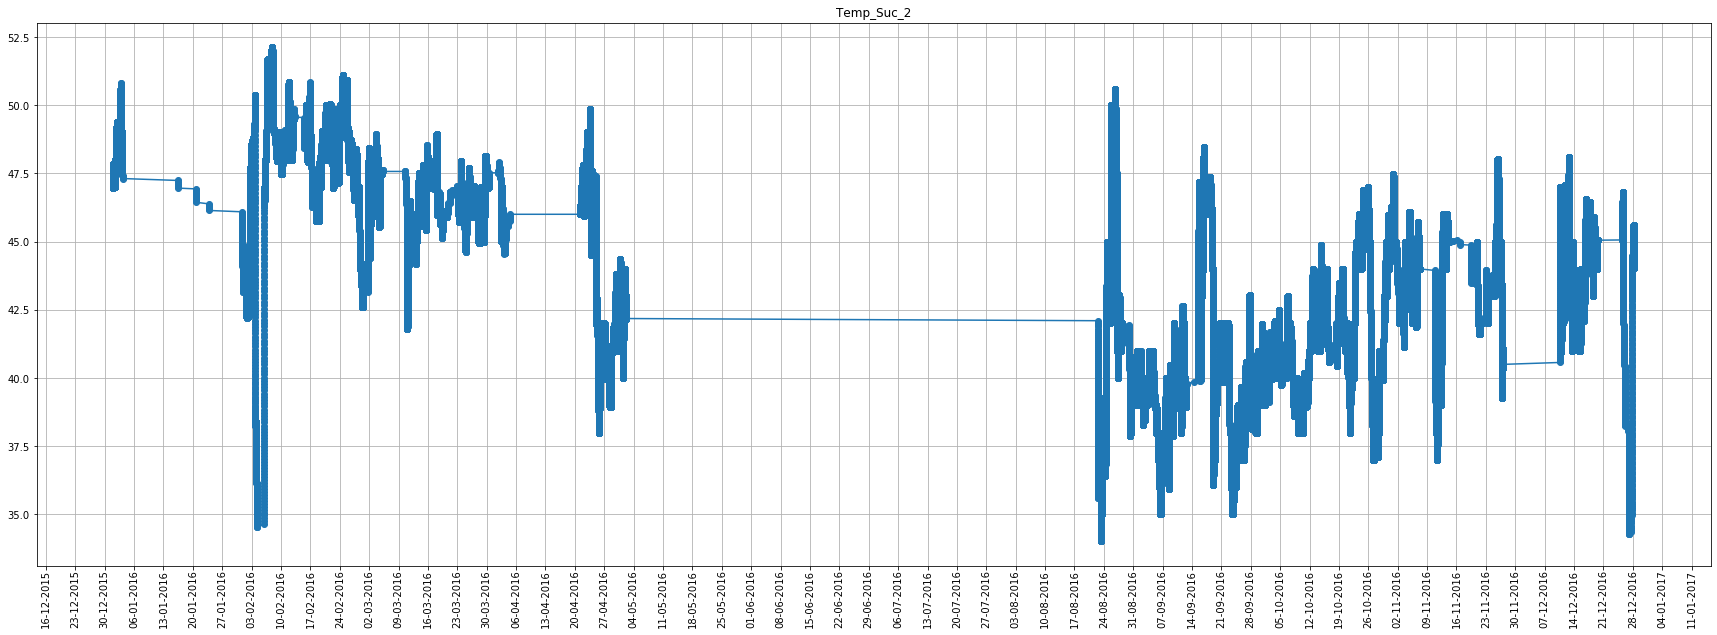

4
(187589, 1)


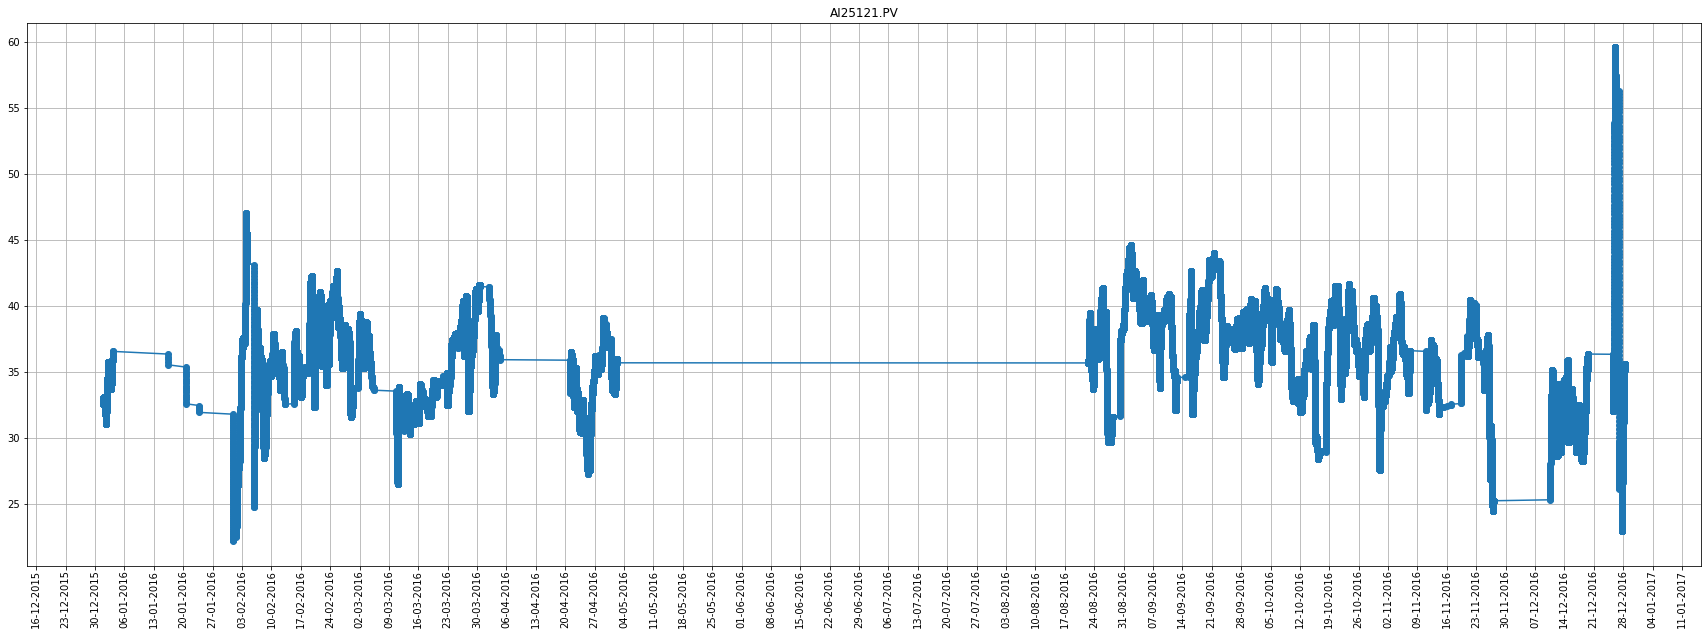

5
(187589, 1)


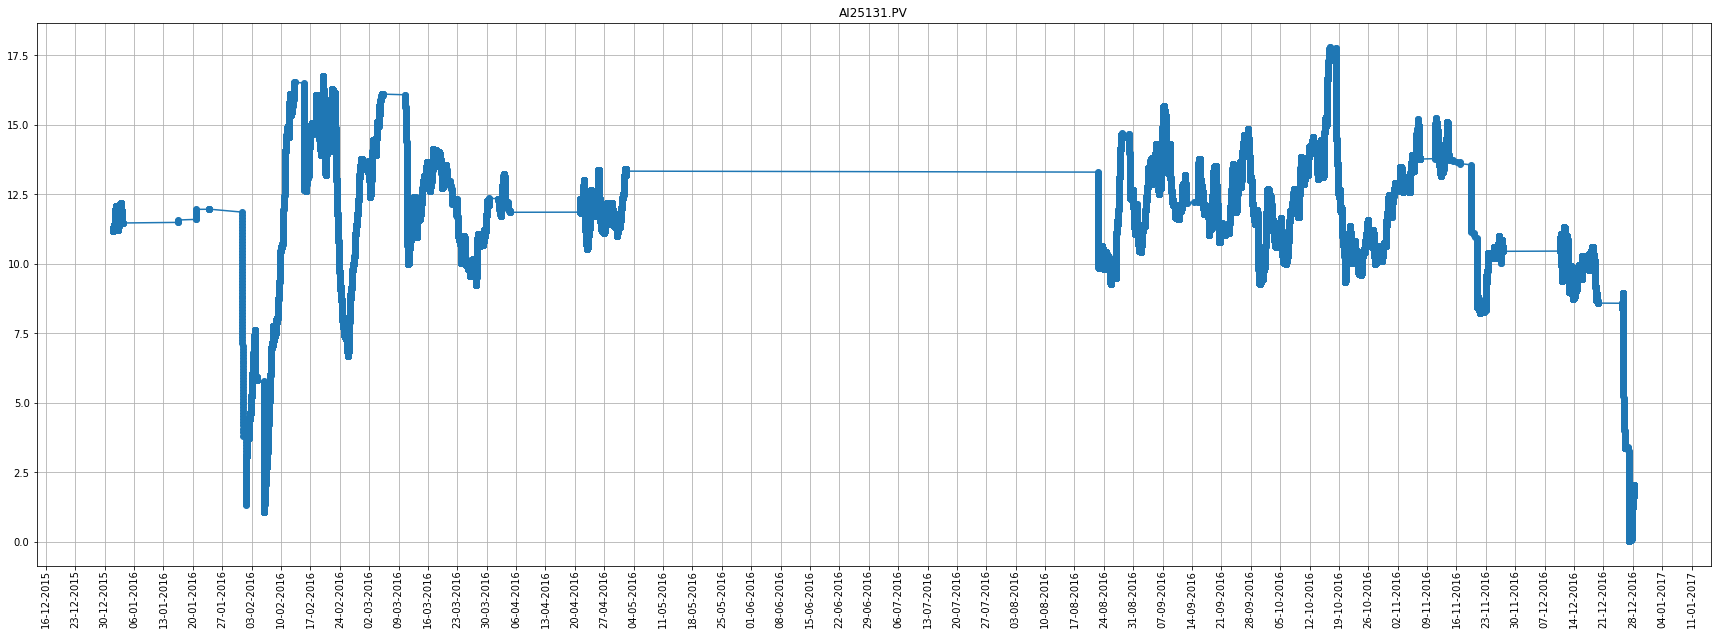

6
(187589, 1)


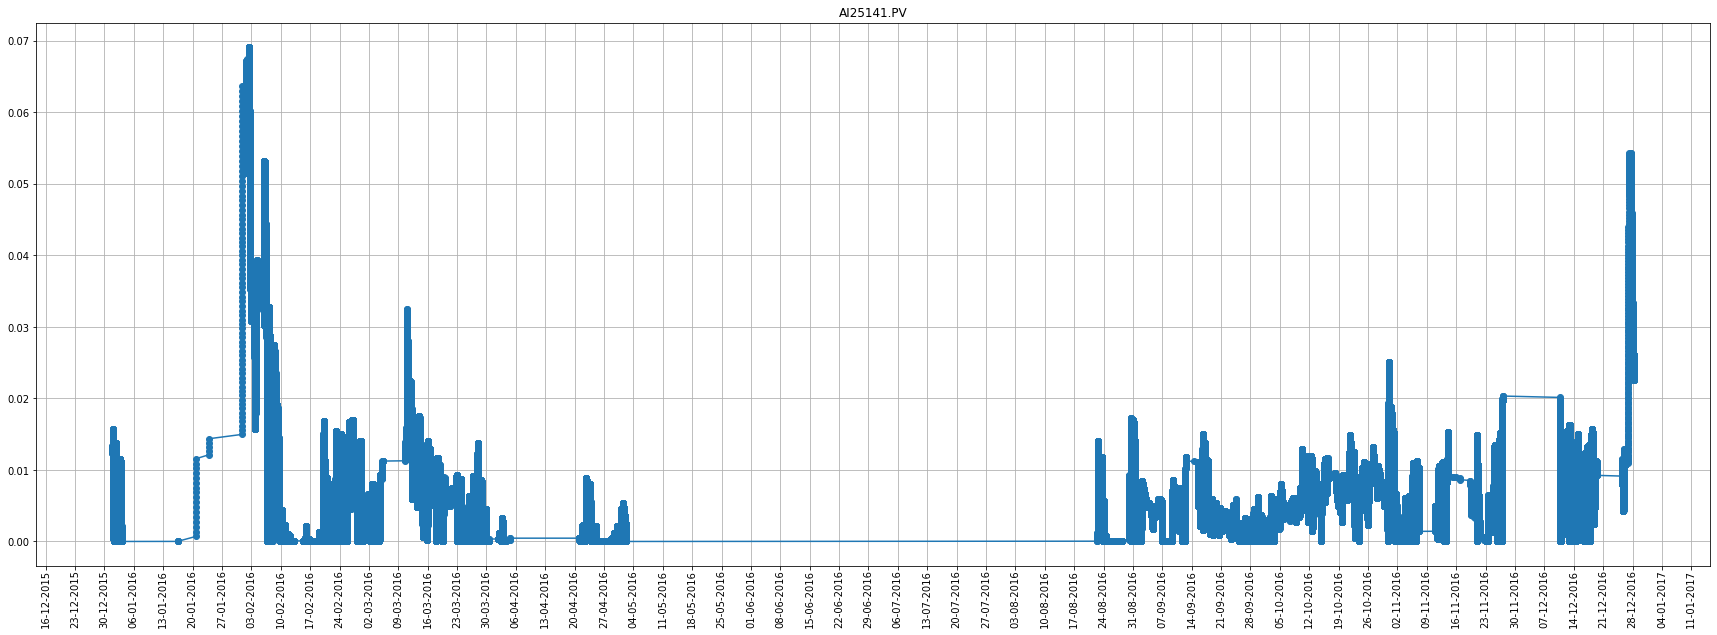

7
(187589, 1)


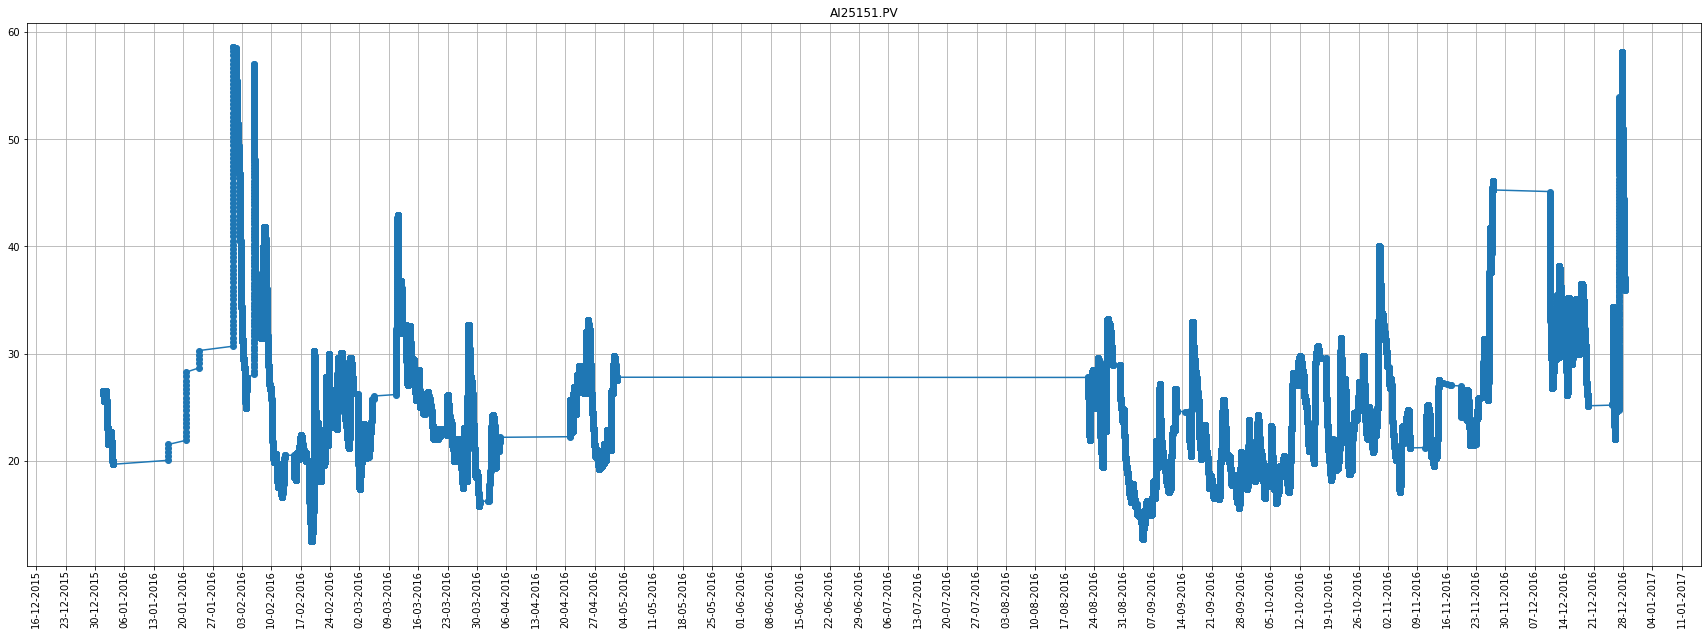

8
(187589, 1)


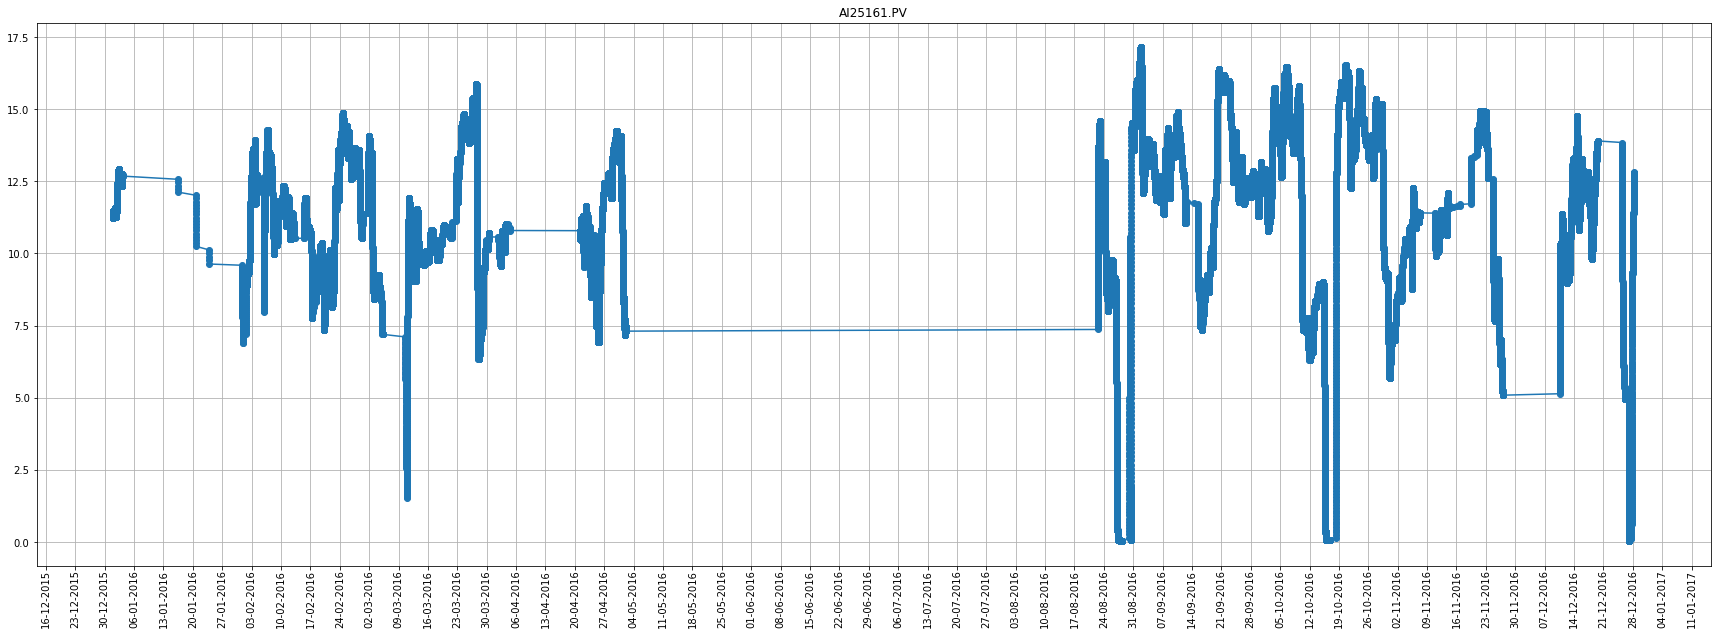

9
(187589, 1)


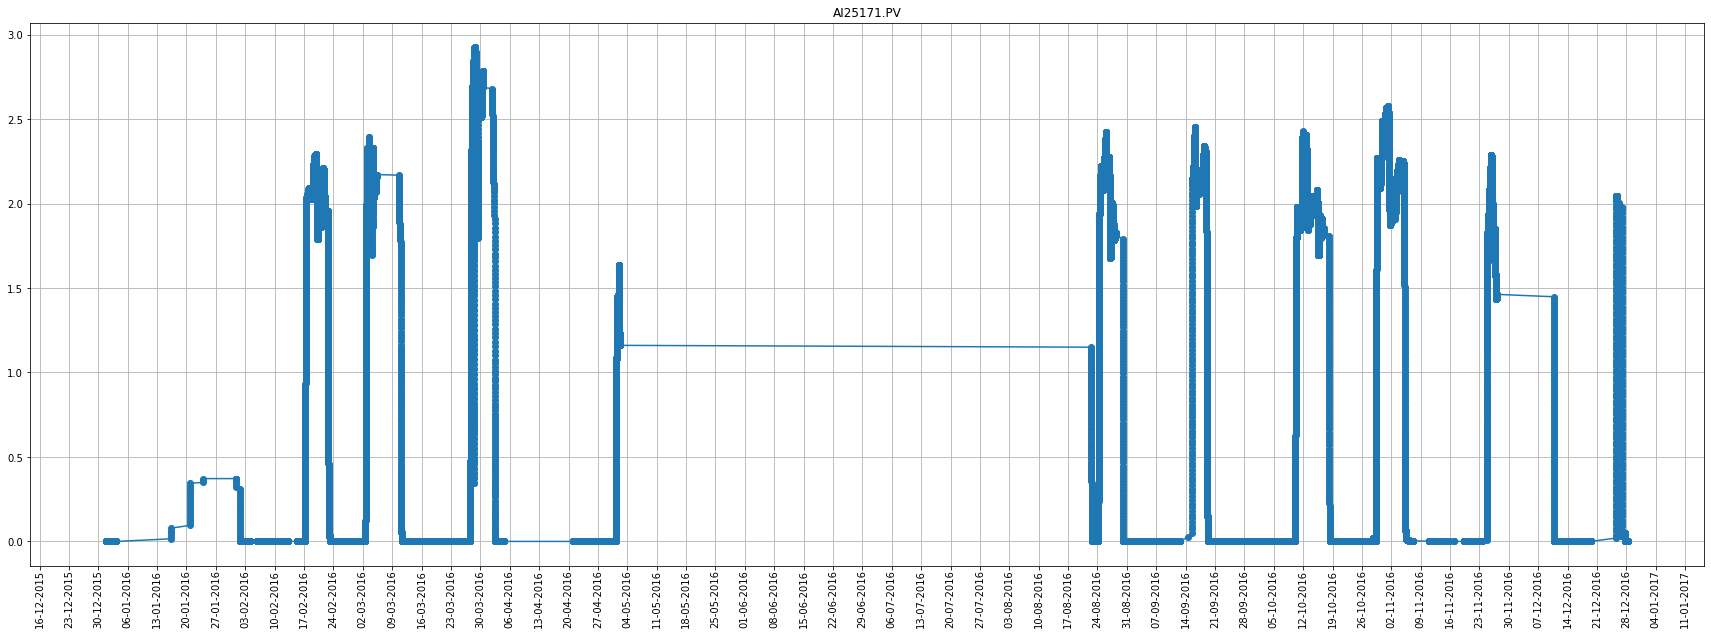

10
(187589, 1)


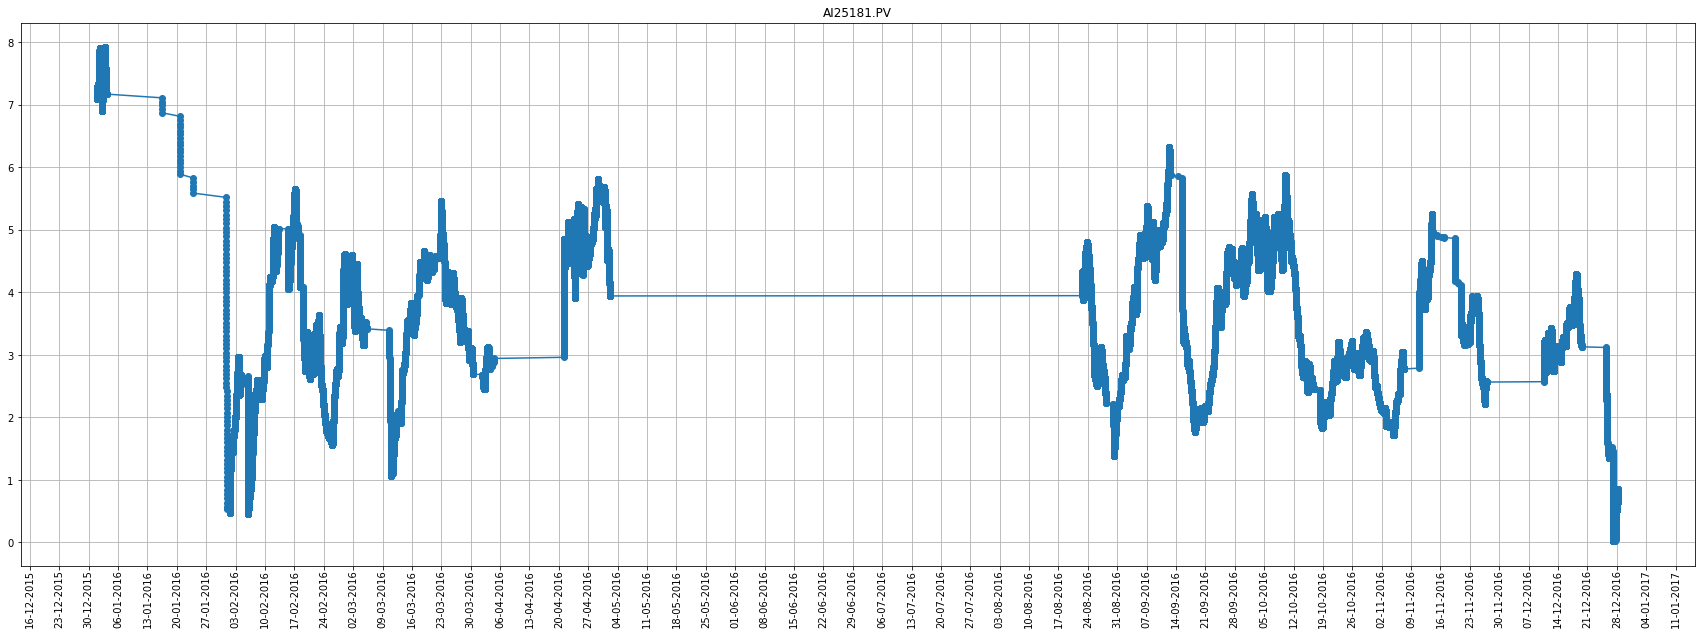

11
(187589, 1)


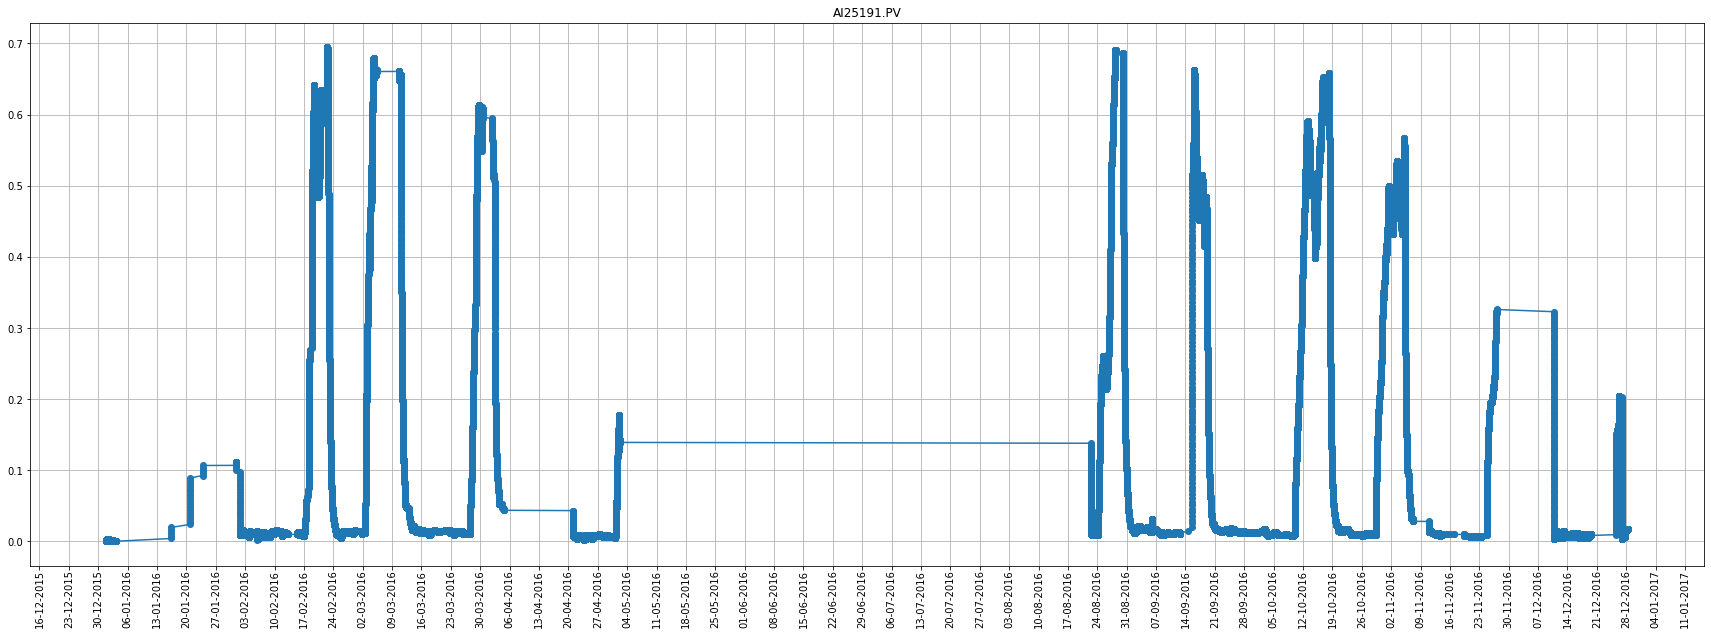

12
(187589, 1)


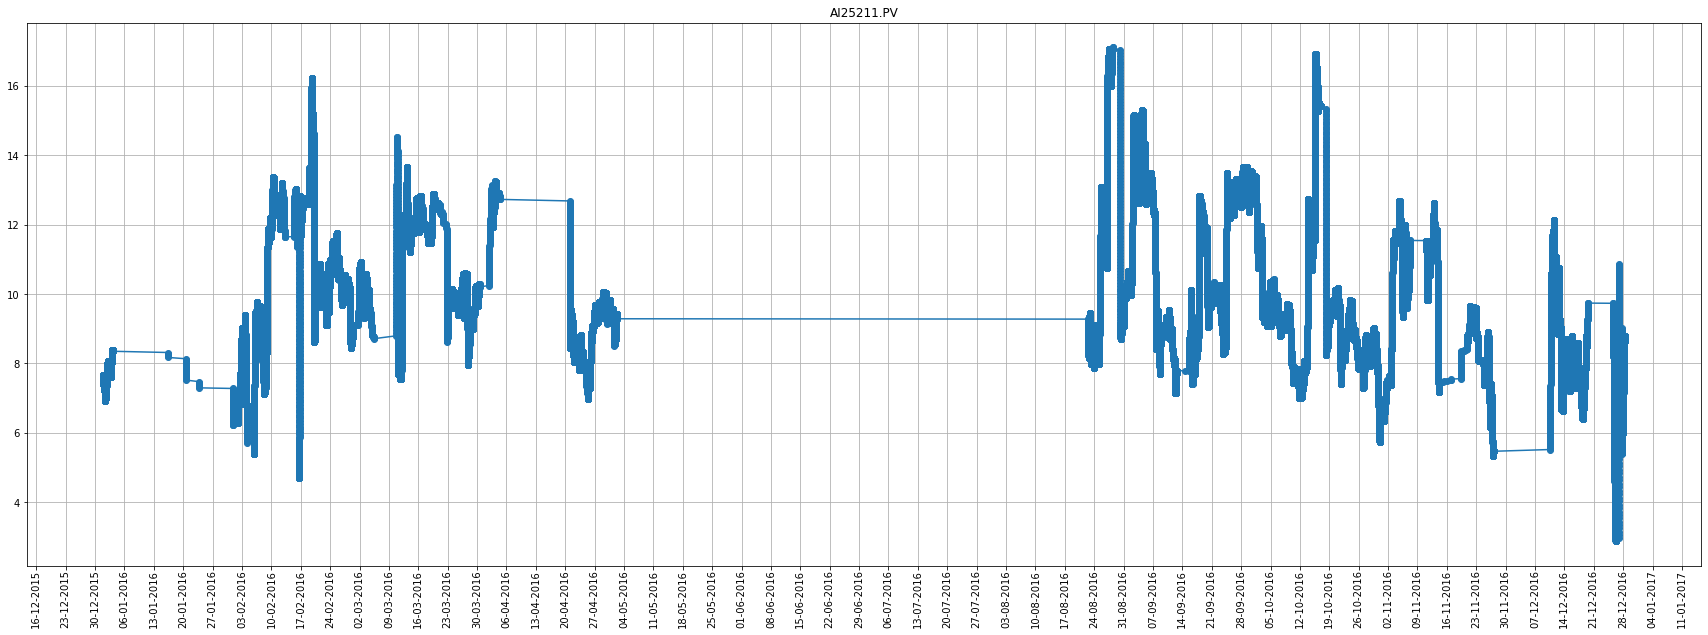

Linear Model
(187589, 2)


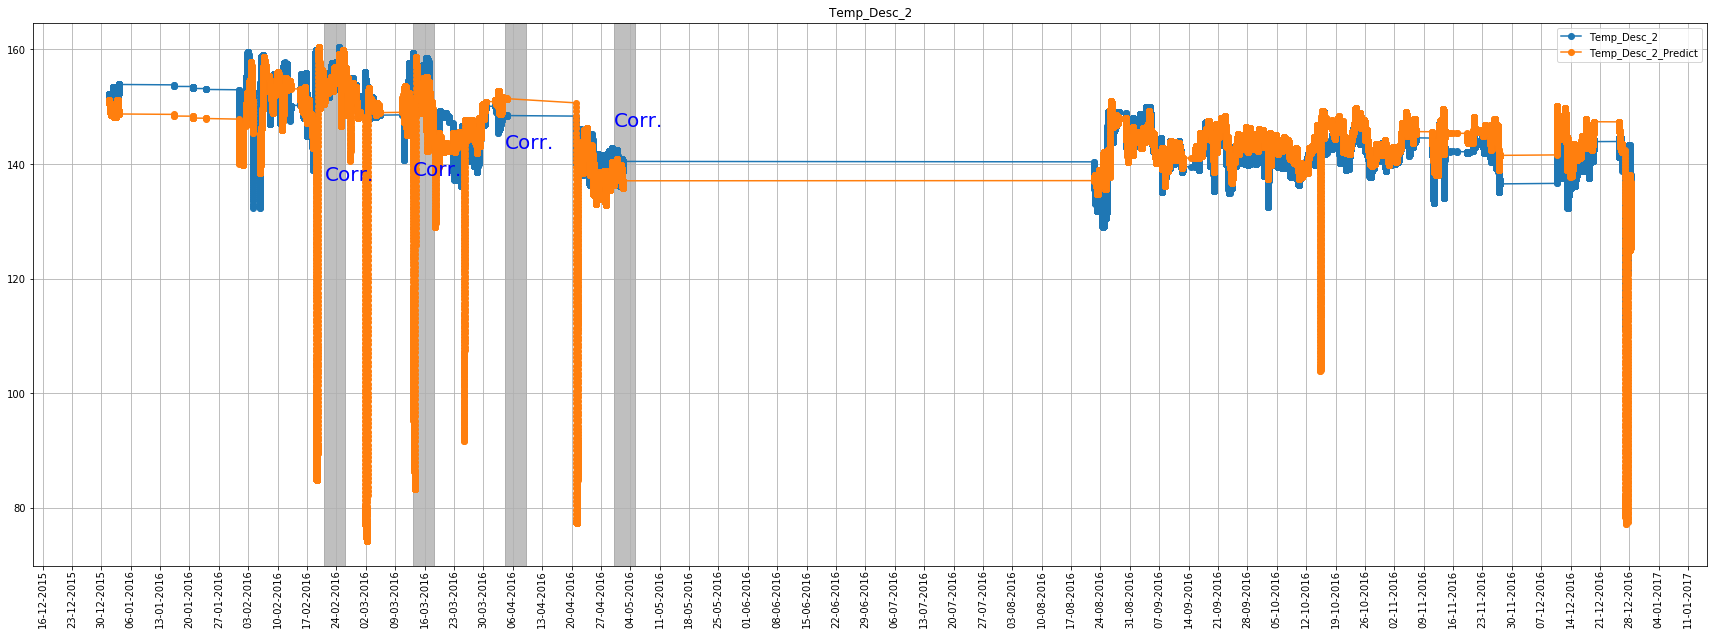

(187589, 1)


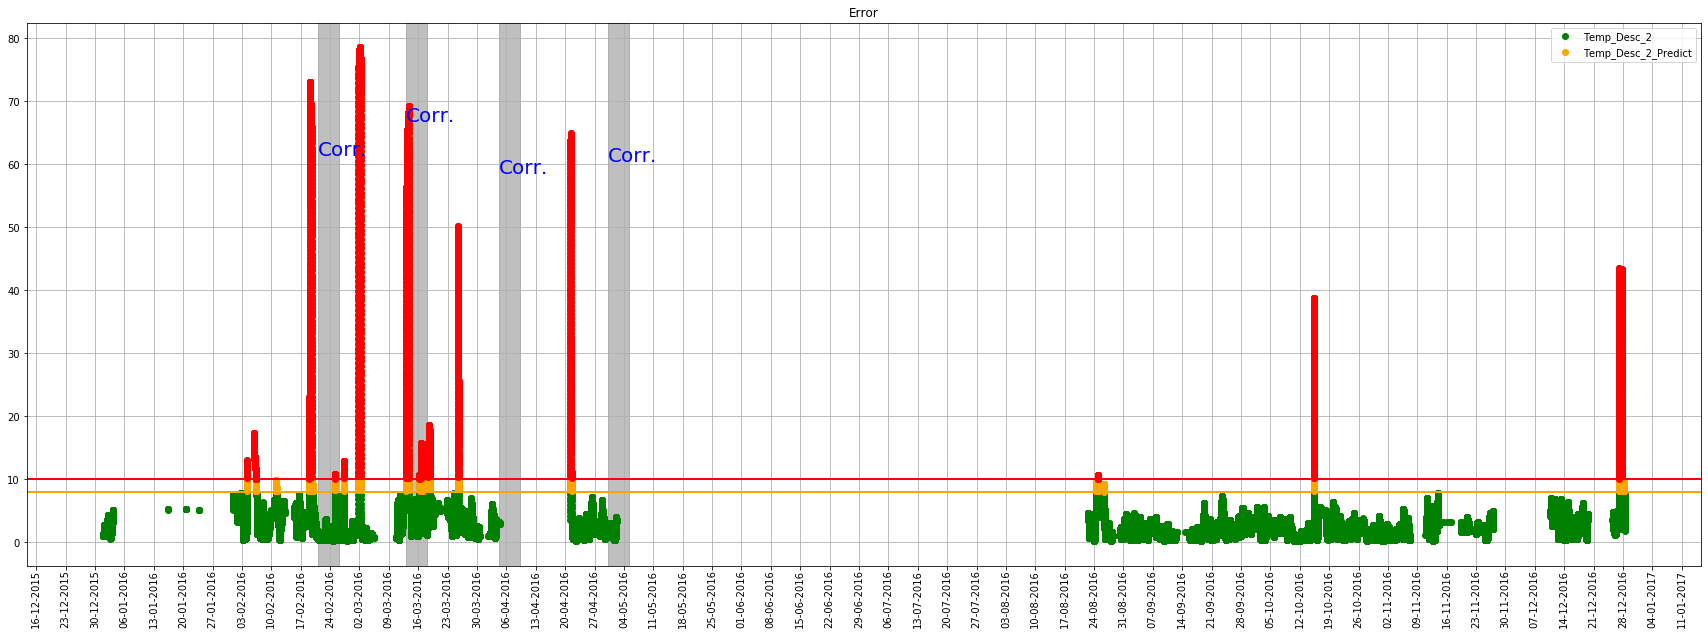

In [29]:
start_date = '01/01/2016 00:00'
end_date = '12/31/2016 00:00'
rolling_time = [100]
days_interval = 7
all_fails = corr

for i in range(0,len(entrada)):
    print(i)
    plot_variables_rolling_V2(df_test,[entrada[i]],start_date,end_date,rolling_time=rolling_time,days_interval=days_interval);
    
print('Linear Model') 
plot_variables_rolling_V2(df_test,[saida[0],prediction_variable],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails );

plot_variables_rolling_V2(df_test,['Error'],start_date,end_date,rolling_time=rolling_time,
                       legend=[saida[0],prediction_variable],
                       days_interval=days_interval,fail_dates=all_fails,trasholds=[8.0,10.0],absolute=True);
